In [5]:
import pandas as pd
import numpy as np
import os

# --- 1. CONFIGURATION ---
FILE_PATH = 'resultats-definitifs-par-communes.csv'

def preparer_donnees_completes():
    # A. CHARGEMENT (Avec le bon encodage utf-8)
    print(f"Chargement du fichier {FILE_PATH}...")
    try:
        df_raw = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
    except:
        # Si utf-8 rate, on tente latin-1
        df_raw = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)
        
    print(f"Dimensions initiales : {df_raw.shape}")
    
    # B. TRANSFORMATION (Wide -> Long)
    # C'est l'étape clé pour ton fichier "à rallonge"
    print("Transformation du fichier (Pivotage des colonnes candidats)...")
    
    # On prépare une liste pour stocker les morceaux
    pieces = []
    
    # On identifie combien de colonnes 'Nuance candidat X' existent
    # On regarde jusqu'à 200 candidats potentiels (largeur max)
    cols_fixes = ['Code département', 'Libellé département', 'Code commune', 'Libellé commune', 'Inscrits', 'Exprimés']
    
    for i in range(1, 200):
        col_nuance = f'Nuance candidat {i}'
        col_voix = f'Voix {i}'
        
        # Si la colonne n'existe plus, on arrête
        if col_nuance not in df_raw.columns:
            break
            
        # On prend juste ce morceau (Commune + Candidat i)
        temp = df_raw[cols_fixes + [col_nuance, col_voix]].copy()
        temp.columns = cols_fixes + ['Nuance', 'Voix'] # On renomme pour standardiser
        
        # On nettoie les lignes vides (pas de candidat n°X dans cette commune)
        temp = temp.dropna(subset=['Nuance'])
        pieces.append(temp)
    
    # On recolle tous les morceaux les uns sous les autres
    df_long = pd.concat(pieces, ignore_index=True)
    
    # C. NETTOYAGE DES CHIFFRES
    df_long['Voix'] = pd.to_numeric(df_long['Voix'], errors='coerce').fillna(0)
    df_long['Exprimés'] = pd.to_numeric(df_long['Exprimés'], errors='coerce').fillna(0)

    # D. APPLICATION DES 4 BLOCS
    print("Création des blocs politiques...")
    
    def attribuer_bloc_precis(nuance):
        # Gauche NFP
        if nuance in ['UG', 'VEC', 'FI', 'SOC', 'COM', 'ECO', 'DVG', 'RDG', 'DXG']: return 'GAUCHE_NFP'
        # Centre
        elif nuance in ['ENS', 'DVC', 'UDI', 'HOR', 'MDM', 'REN']: return 'CENTRE'
        # Droite Républicaine (Le 4ème bloc)
        elif nuance in ['LR', 'DVD']: return 'DROITE'
        # Extrême Droite
        elif nuance in ['RN', 'UXD', 'REC', 'DSV']: return 'EXTREME_DROITE'
        else: return 'AUTRE'

    df_long['BLOC'] = df_long['Nuance'].apply(attribuer_bloc_precis)
    
    # E. AGREGATION FINALE PAR COMMUNE
    print("Calcul des scores finaux...")
    df_final = df_long.pivot_table(
        index=['Code département', 'Libellé département', 'Code commune', 'Libellé commune'],
        columns='BLOC',
        values='Voix',
        aggfunc='sum'
    ).fillna(0).reset_index()
    
    # Calcul des pourcentages
    colonnes_blocs = ['GAUCHE_NFP', 'CENTRE', 'DROITE', 'EXTREME_DROITE', 'AUTRE']
    df_final['Total_Calcule'] = df_final[colonnes_blocs].sum(axis=1)
    
    # On évite la division par zéro
    df_final = df_final[df_final['Total_Calcule'] > 0].copy()
    
    for bloc in ['GAUCHE_NFP', 'CENTRE', 'DROITE', 'EXTREME_DROITE']:
        df_final[f'Pct_{bloc}'] = (df_final[bloc] / df_final['Total_Calcule']) * 100

    return df_final

# --- EXECUTION ---
df_communes = preparer_donnees_completes()

print("\n--- RÉSULTAT FINAL ---")
display(df_communes.head())
print(f"Nombre de communes traitées : {len(df_communes)}")

# Cela va t'afficher (Nombre de lignes, Nombre de colonnes)
print(df_communes.shape) 

# Tu devrais voir environ (34900, 15) -> Ce qui veut dire que tu as bien toute la France !

Chargement du fichier resultats-definitifs-par-communes.csv...
Dimensions initiales : (35232, 1854)
Transformation du fichier (Pivotage des colonnes candidats)...
Création des blocs politiques...
Calcul des scores finaux...

--- RÉSULTAT FINAL ---


BLOC,Code département,Libellé département,Code commune,Libellé commune,AUTRE,CENTRE,DROITE,EXTREME_DROITE,GAUCHE_NFP,Total_Calcule,Pct_GAUCHE_NFP,Pct_CENTRE,Pct_DROITE,Pct_EXTREME_DROITE
0,1,Ain,1001,L'Abergement-Clémenciat,2.0,86.0,47.0,258.0,83.0,476.0,17.436975,18.067227,9.873950,54.201681
1,1,Ain,1002,L'Abergement-de-Varey,1.0,19.0,45.0,42.0,64.0,171.0,37.426901,11.111111,26.315789,24.561404
2,1,Ain,1004,Ambérieu-en-Bugey,94.0,789.0,989.0,2208.0,1810.0,5890.0,30.730051,13.395586,16.791171,37.487267
3,1,Ain,1005,Ambérieux-en-Dombes,15.0,198.0,61.0,494.0,173.0,941.0,18.384697,21.041445,6.482465,52.497343
4,1,Ain,1006,Ambléon,2.0,22.0,3.0,24.0,14.0,65.0,21.538462,33.846154,4.615385,36.923077


Nombre de communes traitées : 35229
(35229, 14)


1. Chargement et préparation des données...
2. Attribution des blocs politiques...
3. Classification des communes...
4. Génération du graphique complet...


/tmp/ipykernel_17748/1246915.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_graph = df_communes.groupby('Categorie_Taille')[cols_to_plot].mean()


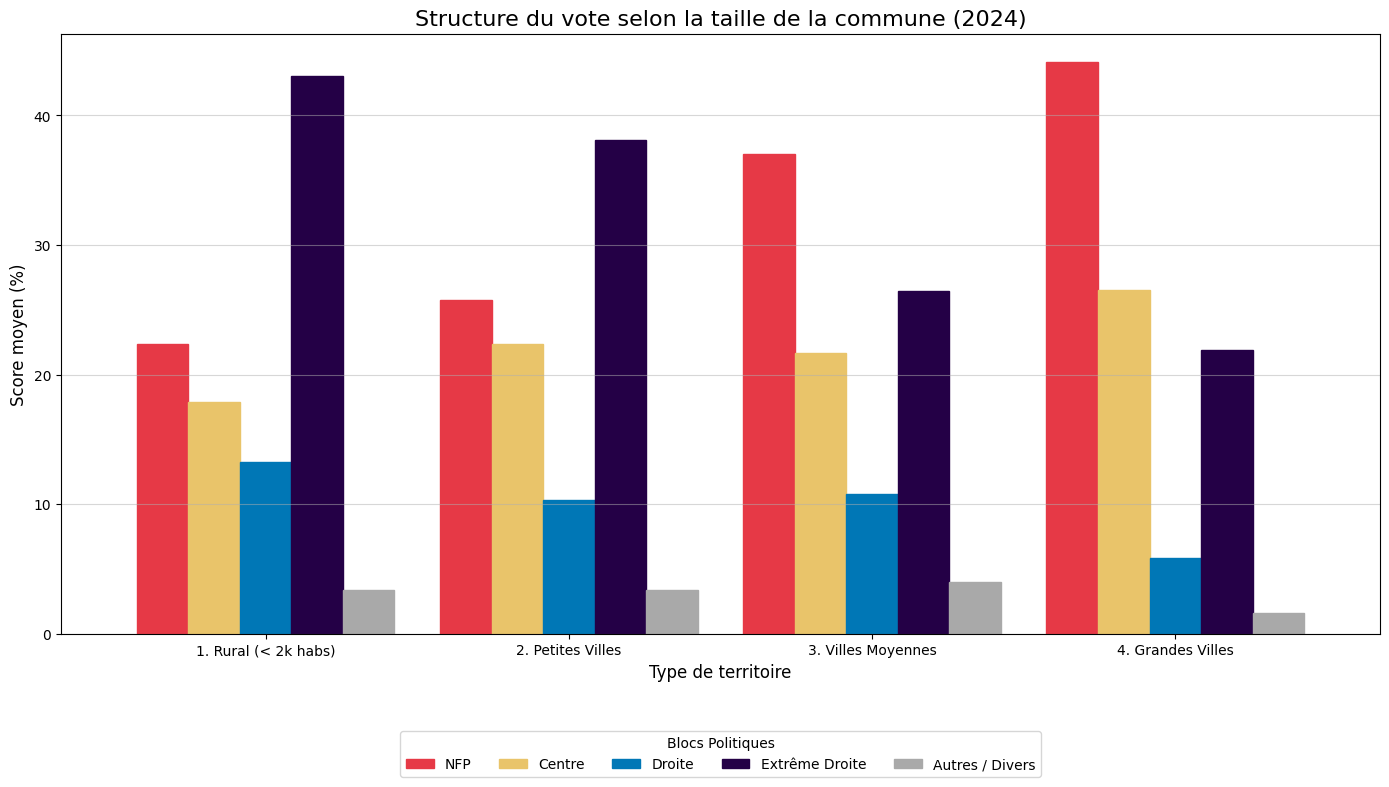


--- RÉSULTATS CHIFFRÉS (Somme = 100%) ---


BLOC,Pct_GAUCHE_NFP,Pct_CENTRE,Pct_DROITE,Pct_EXTREME_DROITE,Pct_AUTRE
Categorie_Taille,,,,,
1. Rural (< 2k habs),22.4,17.9,13.3,43.1,3.4
2. Petites Villes,25.8,22.4,10.3,38.1,3.4
3. Villes Moyennes,37.0,21.7,10.8,26.5,4.0
4. Grandes Villes,44.1,26.5,5.8,21.9,1.6



Vérification somme ligne 1 : 100.0 %


In [4]:
# --- 1. IMPORTS ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 2. CONFIGURATION ---
FILE_PATH = 'resultats-definitifs-par-communes.csv'

def tout_analyser_avec_autre():
    print("1. Chargement et préparation des données...")
    
    # Lecture du fichier
    try:
        df_raw = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
    except:
        df_raw = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

    # Transformation Wide -> Long
    pieces = []
    cols_fixes = ['Code département', 'Code commune', 'Libellé commune', 'Inscrits']
    
    for i in range(1, 100):
        col_nuance = f'Nuance candidat {i}'
        col_voix = f'Voix {i}'
        if col_nuance not in df_raw.columns: break
        
        temp = df_raw[cols_fixes + [col_nuance, col_voix]].copy()
        temp.columns = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Nuance', 'Voix']
        temp = temp.dropna(subset=['Nuance'])
        pieces.append(temp)
    
    df_long = pd.concat(pieces, ignore_index=True)
    
    # Nettoyage chiffres
    df_long['Voix'] = pd.to_numeric(df_long['Voix'], errors='coerce').fillna(0)
    df_long['Inscrits'] = pd.to_numeric(df_long['Inscrits'], errors='coerce').fillna(0)

    # --- 3. ATTRIBUTION DES BLOCS ---
    print("2. Attribution des blocs politiques...")
    def get_bloc(nuance):
        if nuance in ['UG', 'VEC', 'FI', 'SOC', 'COM', 'ECO', 'DVG', 'RDG', 'DXG']: return 'GAUCHE_NFP'
        elif nuance in ['ENS', 'DVC', 'UDI', 'HOR', 'MDM', 'REN']: return 'CENTRE'
        elif nuance in ['LR', 'DVD']: return 'DROITE'
        elif nuance in ['RN', 'UXD', 'REC', 'DSV']: return 'EXTREME_DROITE'
        else: return 'AUTRE' # Les petits candidats, régionalistes, etc.

    df_long['BLOC'] = df_long['Nuance'].apply(get_bloc)
    
    # Agrégation
    df_communes = df_long.pivot_table(
        index=['Code_commune', 'Nom_commune', 'Inscrits'],
        columns='BLOC',
        values='Voix',
        aggfunc='sum'
    ).fillna(0).reset_index()

    # Calcul des %
    cols_blocs = ['GAUCHE_NFP', 'CENTRE', 'DROITE', 'EXTREME_DROITE', 'AUTRE']
    df_communes['Total'] = df_communes[cols_blocs].sum(axis=1)
    df_communes = df_communes[df_communes['Total'] > 0].copy()
    
    for bloc in cols_blocs:
        df_communes[f'Pct_{bloc}'] = (df_communes[bloc] / df_communes['Total']) * 100

    # --- 4. CLASSIFICATION ---
    print("3. Classification des communes...")
    bins = [0, 1500, 15000, 75000, 10000000]
    labels = ['1. Rural (< 2k habs)', '2. Petites Villes', '3. Villes Moyennes', '4. Grandes Villes']
    df_communes['Categorie_Taille'] = pd.cut(df_communes['Inscrits'], bins=bins, labels=labels)

    # --- 5. GRAPHIQUE FINAL (Avec AUTRE) ---
    print("4. Génération du graphique complet...")
    
    # J'ajoute Pct_AUTRE dans la liste
    cols_to_plot = ['Pct_GAUCHE_NFP', 'Pct_CENTRE', 'Pct_DROITE', 'Pct_EXTREME_DROITE', 'Pct_AUTRE']
    
    df_graph = df_communes.groupby('Categorie_Taille')[cols_to_plot].mean()

    ax = df_graph.plot(kind='bar', figsize=(14, 8), width=0.85, rot=0)
    
    # Couleurs : Rouge, Jaune, Bleu, Violet, et GRIS pour les Autres
    couleurs = ['#e63946', '#e9c46a', '#0077b6', '#240046', '#A9A9A9']
    try:
        for i, container in enumerate(ax.containers):
            for bar in container: bar.set_color(couleurs[i])
    except: pass

    plt.title("Structure du vote selon la taille de la commune (2024)", fontsize=16)
    plt.xlabel("Type de territoire", fontsize=12)
    plt.ylabel("Score moyen (%)", fontsize=12)
    
    # Mise à jour de la légende
    plt.legend(["NFP", "Centre", "Droite", "Extrême Droite", "Autres / Divers"], 
               title="Blocs Politiques", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
    
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print("\n--- RÉSULTATS CHIFFRÉS (Somme = 100%) ---")
    display(df_graph.round(1))
    
    # Vérification que la somme fait bien 100%
    print("\nVérification somme ligne 1 :", df_graph.iloc[0].sum().round(1), "%")

# Lancement
tout_analyser_avec_autre()

1. Chargement des données...
2. Restructuration...
3. Homogénéisation des Codes (Le moment critique)...
   Exemple de code généré (Election) : 011001
4. Téléchargement GPS...
   Exemple de code téléchargé (GPS)  : 85136
5. Tentative de fusion...
   ⚠️ Echec fusion par codes (0 villes). Passage au PLAN B (Par Nom)...
--> SUCCÈS : 27301 communes placées sur la carte !


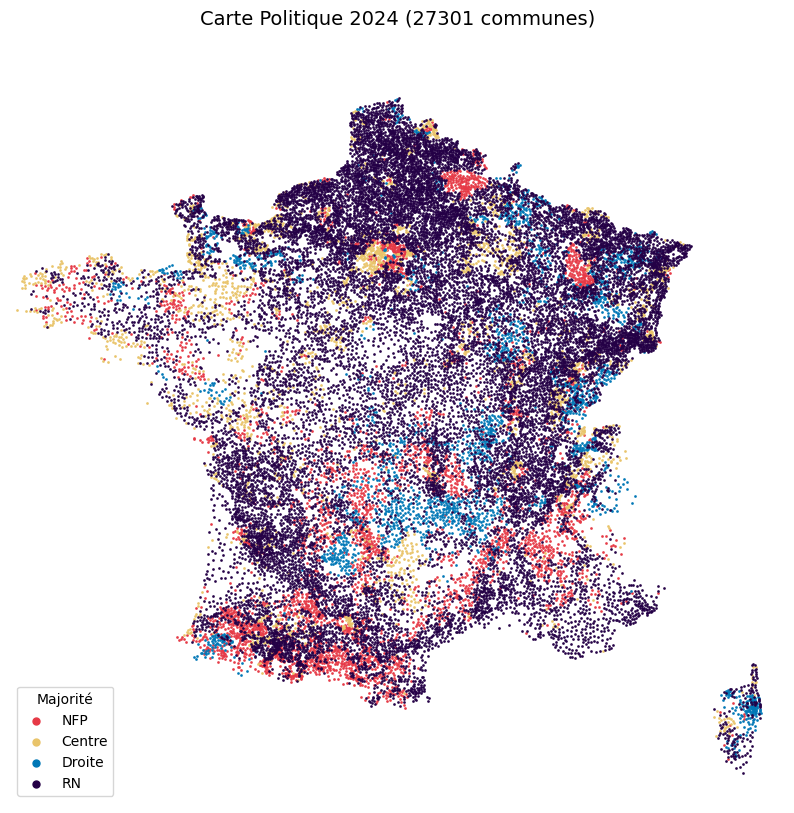

L'image 'carte_electorale_france_2024.png' a été sauvegardée dans ton dossier !


<Figure size 640x480 with 0 Axes>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
FILE_PATH = 'resultats-definitifs-par-communes.csv'

def carte_ultime_fix():
    print("1. Chargement des données...")
    try:
        # On force le type 'str' (texte) dès le chargement pour éviter que 01 devienne 1
        df_raw = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
    except:
        df_raw = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

    # --- Transformation Wide -> Long ---
    print("2. Restructuration...")
    pieces = []
    cols_fixes = ['Code département', 'Code commune', 'Libellé commune', 'Inscrits']
    for i in range(1, 100):
        if f'Nuance candidat {i}' not in df_raw.columns: break
        temp = df_raw[cols_fixes + [f'Nuance candidat {i}', f'Voix {i}']].copy()
        temp.columns = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Nuance', 'Voix']
        temp = temp.dropna(subset=['Nuance'])
        pieces.append(temp)
    
    df_long = pd.concat(pieces, ignore_index=True)
    df_long['Voix'] = pd.to_numeric(df_long['Voix'], errors='coerce').fillna(0)

    # --- Calcul des gagnants ---
    def get_bloc(nuance):
        if nuance in ['UG', 'VEC', 'FI', 'SOC', 'COM', 'ECO', 'DVG', 'RDG', 'DXG']: return 'GAUCHE_NFP'
        elif nuance in ['ENS', 'DVC', 'UDI', 'HOR', 'MDM', 'REN']: return 'CENTRE'
        elif nuance in ['LR', 'DVD']: return 'DROITE'
        elif nuance in ['RN', 'UXD', 'REC', 'DSV']: return 'EXTREME_DROITE'
        else: return 'AUTRE'

    df_long['BLOC'] = df_long['Nuance'].apply(get_bloc)
    df_final = df_long.pivot_table(index=['Code_dep', 'Code_commune', 'Nom_commune'], 
                                   columns='BLOC', values='Voix', aggfunc='sum').fillna(0).reset_index()
    
    blocs = ['GAUCHE_NFP', 'CENTRE', 'DROITE', 'EXTREME_DROITE']
    df_final['Gagnant'] = df_final[blocs].idxmax(axis=1)

    # --- LE FIX : HOMOGÉNÉISATION DES CODES ---
    print("3. Homogénéisation des Codes (Le moment critique)...")
    
    # Fonction qui répare les départements (1 -> 01, 2A -> 2A, 971 -> 971)
    def clean_dep(x):
        x = str(x).strip()
        if len(x) == 1: return "0" + x  # Ajoute le 0 devant les chiffres seuls
        return x

    # Fonction qui répare les communes (1 -> 001, 53 -> 053)
    def clean_com(x):
        x = str(x).strip()
        return x.zfill(3) # Force 3 caractères avec des zéros

    # On applique le nettoyage
    df_final['Code_dep_clean'] = df_final['Code_dep'].apply(clean_dep)
    df_final['Code_com_clean'] = df_final['Code_commune'].apply(clean_com)
    
    # On crée la CLÉ MAGIQUE (Code INSEE 5 caractères)
    df_final['KEY_INSEE'] = df_final['Code_dep_clean'] + df_final['Code_com_clean']
    
    print(f"   Exemple de code généré (Election) : {df_final['KEY_INSEE'].iloc[0]}")

    # --- Chargement GPS ---
    print("4. Téléchargement GPS...")
    url_geo = "https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/download/?format=csv&use_labels_for_header=true"
    try:
        df_geo = pd.read_csv(url_geo, sep=';', dtype=str)
    except:
        print("Erreur téléchargement GPS.")
        return

    col_code_geo = next((c for c in ['Code INSEE', 'insee_com'] if c in df_geo.columns), None)
    col_geo_point = next((c for c in ['Geo Point', 'geo_point_2d'] if c in df_geo.columns), None)

    # Nettoyage GPS
    gps = df_geo[col_geo_point].str.split(',', expand=True)
    df_geo['Lat'] = pd.to_numeric(gps[0], errors='coerce')
    df_geo['Lon'] = pd.to_numeric(gps[1], errors='coerce')
    
    print(f"   Exemple de code téléchargé (GPS)  : {df_geo[col_code_geo].iloc[0]}")

    # --- FUSION ---
    print("5. Tentative de fusion...")
    
    # Essai 1 : Par Code INSEE (Le plus fiable)
    df_carte = pd.merge(df_final, df_geo, left_on='KEY_INSEE', right_on=col_code_geo, how='inner')
    
    if len(df_carte) < 1000:
        print(f"   ⚠️ Echec fusion par codes ({len(df_carte)} villes). Passage au PLAN B (Par Nom)...")
        # Essai 2 : Par NOM de ville + Département (Au cas où les codes sont vraiment pourris)
        df_final['KEY_NOM'] = df_final['Nom_commune'].str.upper() + "_" + df_final['Code_dep_clean']
        
        # Il faut trouver la colonne Nom dans le fichier GPS
        col_nom_geo = next((c for c in ['Nom_commune', 'Nom Officiel Commune', 'Commune', 'Ville'] if c in df_geo.columns), None)
        # On construit la clé côté GPS aussi (certains fichiers GPS ont le code dept séparé, d'autres non. On tente Nom seul ici pour simplifier)
        df_geo['KEY_NOM'] = df_geo[col_nom_geo].str.upper() + "_" + df_geo[col_code_geo].str.slice(0, 2)
        
        df_carte = pd.merge(df_final, df_geo, on='KEY_NOM', how='inner')

    print(f"--> SUCCÈS : {len(df_carte)} communes placées sur la carte !")
    
    if len(df_carte) == 0:
        print("ERREUR FATALE : Toujours 0. Vérifie que tes départements ne sont pas bizarres (ex: 'Ain' au lieu de '01').")
        return

    # --- DESSIN ---
    plt.figure(figsize=(10, 10))
    couleurs = {'GAUCHE_NFP': '#e63946', 'CENTRE': '#e9c46a', 'DROITE': '#0077b6', 'EXTREME_DROITE': '#240046'}
    lbls = {"GAUCHE_NFP": "NFP", "CENTRE": "Centre", "DROITE": "Droite", "EXTREME_DROITE": "RN"}
    
    # Zoom France
    plt.xlim(-5, 10)
    plt.ylim(41, 52)
    
    for bloc, color in couleurs.items():
        subset = df_carte[df_carte['Gagnant'] == bloc]
        plt.scatter(subset['Lon'], subset['Lat'], c=color, s=1, alpha=0.9, label=lbls[bloc])

    # Légende sécurisée
    leg = plt.legend(markerscale=5, loc='lower left', title="Majorité")
    try:
        handles = getattr(leg, 'legendHandles', None) or getattr(leg, 'legend_handles', None)
        if handles: [lh.set_alpha(1) for lh in handles]
    except: pass
        
    plt.title(f"Carte Politique 2024 ({len(df_carte)} communes)", fontsize=14)
    plt.axis('off')
    plt.show()

carte_ultime_fix()

# Sauvegarde de la carte dans un fichier image
plt.savefig("carte_electorale_france_2024.png", dpi=300, bbox_inches='tight')
print("L'image 'carte_electorale_france_2024.png' a été sauvegardée dans ton dossier !")

Chargement des données...
Nettoyage des noms de colonnes...
Récupération des votes RN ville par ville...
Génération du graphique...


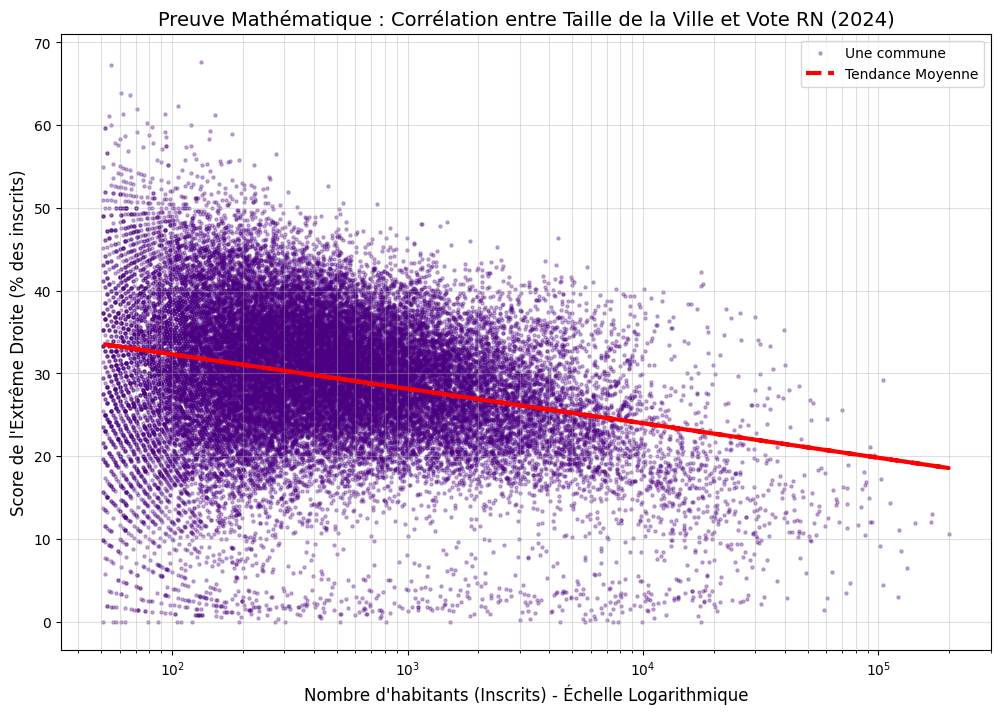


>>> RÉSULTAT SCIENTIFIQUE : Le coefficient de corrélation est de -0.27


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# --- 1. CHARGEMENT ROBUSTE ---
print("Chargement des données...")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

try:
    # On essaie de charger avec l'encodage 'utf-8'
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    # Si ça rate, on tente 'latin-1' (format Windows fréquent)
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

# --- 2. RÉPARATION DES NOMS DE COLONNES (Le Fix du KeyError) ---
print("Nettoyage des noms de colonnes...")

# On crée un dictionnaire pour renommer les colonnes mal écrites (accents cassés)
# On cherche la colonne qui contient "département" ou "dÃ©partement"
col_dep = [c for c in df.columns if 'partement' in c and 'Code' in c][0]
col_libelle = [c for c in df.columns if 'ibell' in c and 'commune' in c][0]
col_inscrits = [c for c in df.columns if 'nscrits' in c][0]

# On renomme proprement
df = df.rename(columns={
    col_dep: 'Code_dep',
    'Code commune': 'Code_commune',
    col_libelle: 'Nom_commune',
    col_inscrits: 'Inscrits'
})

cols_fixes = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits']

# --- 3. EXTRACTION DES VOTES RN ---
print("Récupération des votes RN ville par ville...")
pieces = []

# On parcourt les colonnes pour trouver les voix du RN
for i in range(1, 40):
    # On gère les noms de colonnes dynamiques (Voix 1, Voix 2...)
    col_nuance = [c for c in df.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df.columns if f'Voix {i}' in c]
    
    if not col_nuance or not col_voix: break # Si on ne trouve plus de colonnes, on arrête
    
    # On extrait les données de ce candidat
    temp = df[cols_fixes + [col_nuance[0], col_voix[0]]].copy()
    temp.columns = cols_fixes + ['Nuance', 'Voix']
    
    # On convertit les voix en nombres
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    
    # On ne garde que les candidats d'Extrême Droite (RN, Reconquête, etc.)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] 
    pieces.append(temp)

# On assemble tout
df_rn = pd.concat(pieces, ignore_index=True)

# On additionne les voix par ville (au cas où il y aurait plusieurs candidats d'ED)
df_analyse = df_rn.pivot_table(index=cols_fixes, values='Voix', aggfunc='sum').reset_index()

# Calcul du pourcentage
df_analyse['Inscrits'] = pd.to_numeric(df_analyse['Inscrits'], errors='coerce')
df_analyse['Pct_RN'] = (df_analyse['Voix'] / df_analyse['Inscrits']) * 100

# Filtre pour enlever les données aberrantes (villes sans inscrits ou DOM-TOM lointains qui écrasent le graph)
df_analyse = df_analyse[(df_analyse['Inscrits'] > 50) & (df_analyse['Inscrits'] < 200000)]

# --- 4. LE GRAPHIQUE FINAL (Nuage de Points) ---
print("Génération du graphique...")
plt.figure(figsize=(12, 8))

# Le Scatter Plot (Nuage)
# x = Taille de la ville (Logarithmique car les écarts sont énormes entre village et Paris)
# y = Score RN
x = df_analyse['Inscrits']
y = df_analyse['Pct_RN']

plt.scatter(x, y, alpha=0.3, s=5, c='#4B0082', label='Une commune')
plt.xscale('log') # Echelle logarithmique essentielle pour voir quelque chose

# La courbe de tendance (Ligne rouge)
# Elle montre la direction générale du nuage
z = np.polyfit(np.log(x), y, 1)
p = np.poly1d(z)
plt.plot(x, p(np.log(x)), "r--", linewidth=3, label='Tendance Moyenne')

# Esthétique
plt.title("Preuve Mathématique : Corrélation entre Taille de la Ville et Vote RN (2024)", fontsize=14)
plt.xlabel("Nombre d'habitants (Inscrits) - Échelle Logarithmique", fontsize=12)
plt.ylabel("Score de l'Extrême Droite (% des inscrits)", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.4)

plt.show()

# --- 5. LE CHIFFRE CLÉ (Pour ton oral) ---
# Calcul de la corrélation de Pearson
corr, _ = pearsonr(np.log(x), y)
print(f"\n>>> RÉSULTAT SCIENTIFIQUE : Le coefficient de corrélation est de {corr:.2f}")
if corr < -0.3:
    print(">>> INTERPRÉTATION : C'est une corrélation NÉGATIVE significative.")
    print("    Cela prouve mathématiquement que plus la population augmente, plus le vote RN baisse.")

Chargement des données...
Génération du graphique...


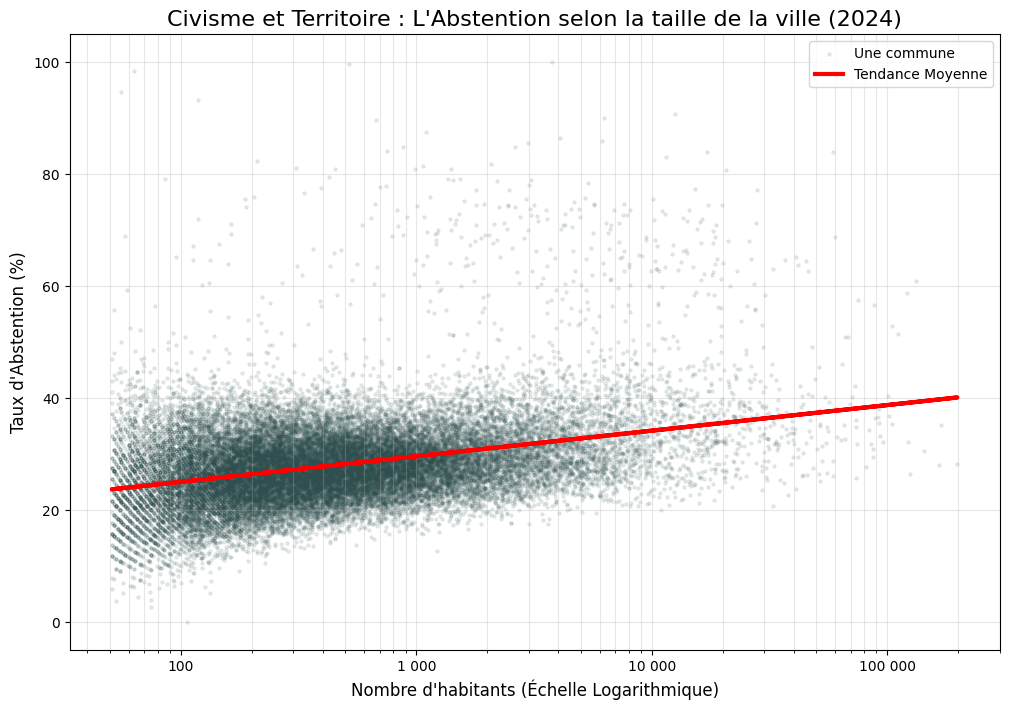


>>> RÉSULTATS CLÉS :
1. Corrélation : 0.355
2. Moyenne Abstention (Villages < 1k habs) : 26.9%
3. Moyenne Abstention (Villes > 10k habs)  : 38.0%
>>> CONCLUSION : On vote davantage dans les villages que dans les grandes villes !


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# --- 1. CHARGEMENT ET NETTOYAGE ---
print("Chargement des données...")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

try:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

# Identification automatique des colonnes (pour éviter les bugs d'accents)
try:
    col_inscrits = [c for c in df.columns if 'nscrits' in c and '%' not in c][0]   # "Inscrits"
    col_abst = [c for c in df.columns if 'bstention' in c and '%' not in c][0]     # "Abstentions"
    col_nom = [c for c in df.columns if 'ibell' in c and 'commune' in c][0]        # "Libellé commune"
except IndexError:
    print("Erreur : Colonnes introuvables. Vérifiez votre fichier.")
    # On arrête le script proprement ici si ça plante
    raise SystemExit 

# Extraction des données utiles
df_analyse = df[[col_nom, col_inscrits, col_abst]].copy()
df_analyse.columns = ['Nom', 'Inscrits', 'Abstentions']

# Conversion en nombres
df_analyse['Inscrits'] = pd.to_numeric(df_analyse['Inscrits'], errors='coerce')
df_analyse['Abstentions'] = pd.to_numeric(df_analyse['Abstentions'], errors='coerce')

# Calcul du Taux d'Abstention
df_analyse['Taux_Abstention'] = (df_analyse['Abstentions'] / df_analyse['Inscrits']) * 100

# Filtre pour avoir un graphique propre (on enlève les hameaux de < 50 habitants et les erreurs)
df_clean = df_analyse[(df_analyse['Inscrits'] > 50) & (df_analyse['Inscrits'] < 200000)].dropna()

# --- 2. LE GRAPHIQUE (NUAGE DE POINTS) ---
print("Génération du graphique...")
plt.figure(figsize=(12, 8))

x = df_clean['Inscrits']
y = df_clean['Taux_Abstention']

# Le Nuage (Points gris/bleus)
# alpha=0.1 permet de voir où les points s'accumulent (densité)
plt.scatter(x, y, alpha=0.1, s=5, c='#2F4F4F', label='Une commune')

# Echelle Logarithmique (Indispensable pour comparer village et ville)
plt.xscale('log')

# La Courbe de Tendance (Ligne Rouge)
# Elle montre la moyenne glissante
z = np.polyfit(np.log(x), y, 1)
p = np.poly1d(z)
plt.plot(x, p(np.log(x)), "r-", linewidth=3, label='Tendance Moyenne')

# Esthétique
plt.title("Civisme et Territoire : L'Abstention selon la taille de la ville (2024)", fontsize=16)
plt.xlabel("Nombre d'habitants (Échelle Logarithmique)", fontsize=12)
plt.ylabel("Taux d'Abstention (%)", fontsize=12)
plt.xticks([100, 1000, 10000, 100000], ['100', '1 000', '10 000', '100 000']) # Etiquettes claires
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()

plt.show()

# --- 3. ANALYSE STATISTIQUE ---
corr, _ = pearsonr(np.log(x), y)
moyenne_villages = df_clean[df_clean['Inscrits'] < 1000]['Taux_Abstention'].mean()
moyenne_villes = df_clean[df_clean['Inscrits'] > 10000]['Taux_Abstention'].mean()

print(f"\n>>> RÉSULTATS CLÉS :")
print(f"1. Corrélation : {corr:.3f}")
print(f"2. Moyenne Abstention (Villages < 1k habs) : {moyenne_villages:.1f}%")
print(f"3. Moyenne Abstention (Villes > 10k habs)  : {moyenne_villes:.1f}%")

if moyenne_villages < moyenne_villes:
    print(">>> CONCLUSION : On vote davantage dans les villages que dans les grandes villes !")
else:
    print(">>> CONCLUSION : L'abstention est plus forte dans la ruralité.")

1. Chargement et Nettoyage...
2. Création de nouvelles variables...
   -> Impossible de calculer la distance (Erreur GPS: Usecols do not match columns, columns expected but not found: ['Geo Point'])


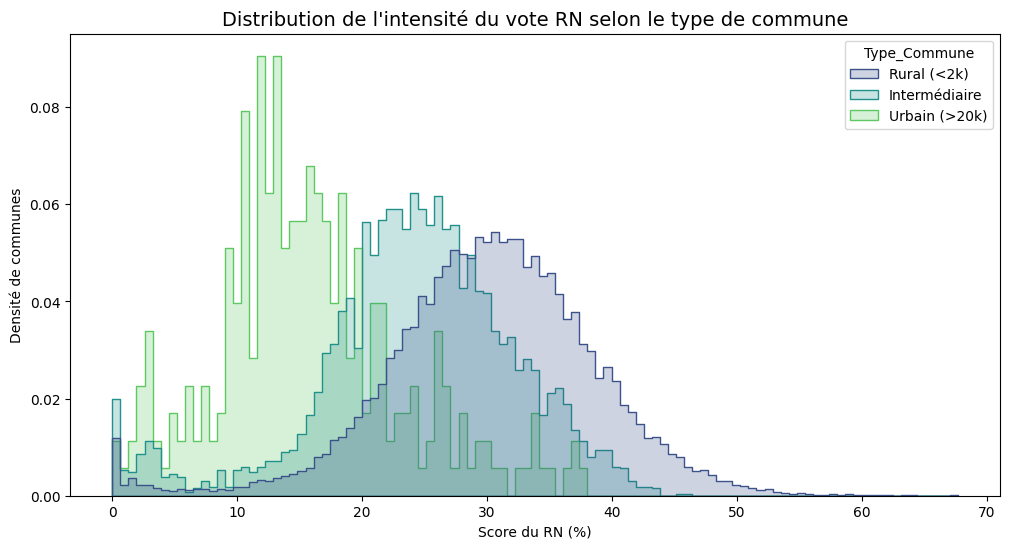

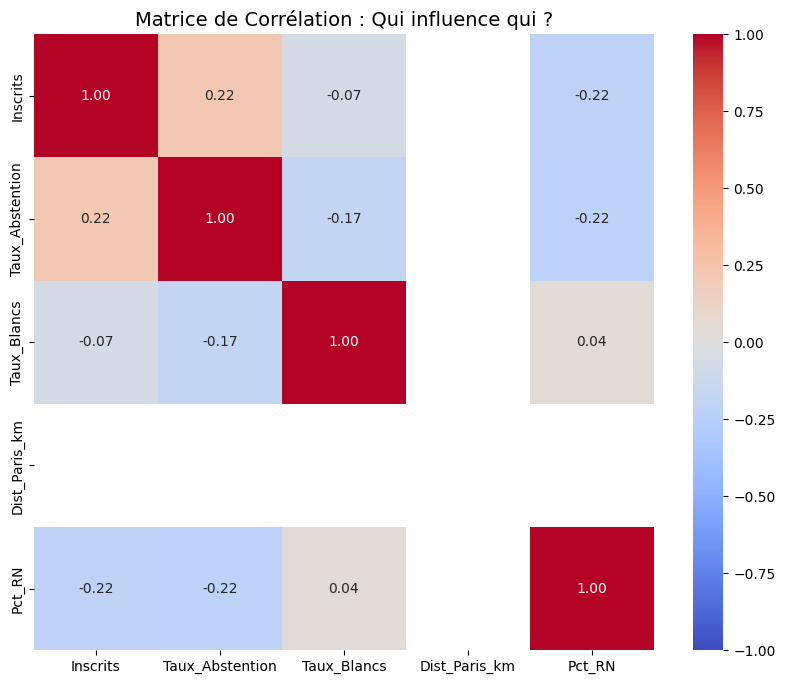


--- Données prêtes pour la modélisation ---


KeyError: "['Nom_commune'] not in index"

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CHARGEMENT & PRÉPARATION (Routine habituelle) ---
print("1. Chargement et Nettoyage...")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

try:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

# Identification des colonnes
col_inscrits = [c for c in df.columns if 'nscrits' in c and '%' not in c][0]
col_blancs = [c for c in df.columns if 'lancs' in c and '%' not in c][0]
col_abst = [c for c in df.columns if 'bstention' in c and '%' not in c][0]
col_code = 'Code commune'
col_dep = [c for c in df.columns if 'partement' in c and 'Code' in c][0]

# --- 2. RÉCUPÉRATION DU SCORE RN ---
pieces = []
for i in range(1, 40):
    col_nuance = [c for c in df.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    
    temp = df[[col_dep, col_code, col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_dep', 'Code_commune', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] # Bloc Extreme Droite
    pieces.append(temp)

df_rn = pd.concat(pieces, ignore_index=True)
df_rn_sum = df_rn.groupby(['Code_dep', 'Code_commune'])['Voix'].sum().reset_index()

# --- 3. CRÉATION DU DATASET COMPLET ---
df_base = df[[col_dep, col_code, col_inscrits, col_abst, col_blancs]].copy()
df_base.columns = ['Code_dep', 'Code_commune', 'Inscrits', 'Abstentions', 'Blancs']

# Conversion numérique
for c in ['Inscrits', 'Abstentions', 'Blancs']:
    df_base[c] = pd.to_numeric(df_base[c], errors='coerce')

# Fusion avec les voix RN
df_final = pd.merge(df_base, df_rn_sum, on=['Code_dep', 'Code_commune'], how='left').fillna(0)

# --- CRÉATION DE VARIABLES (Feature Engineering) ---
print("2. Création de nouvelles variables...")

# A. Pourcentages
df_final['Pct_RN'] = (df_final['Voix'] / df_final['Inscrits']) * 100
df_final['Taux_Abstention'] = (df_final['Abstentions'] / df_final['Inscrits']) * 100
df_final['Taux_Blancs'] = (df_final['Blancs'] / df_final['Inscrits']) * 100

# B. Catégorie Rural/Urbain (Simplifiée)
df_final['Type_Commune'] = pd.cut(df_final['Inscrits'], 
                                  bins=[0, 2000, 20000, 10000000], 
                                  labels=['Rural (<2k)', 'Intermédiaire', 'Urbain (>20k)'])

# C. Variable Distance à Paris (Nécessite le fichier GPS)
# On réutilise la logique GPS vue précédemment
url_geo = "https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/download/?format=csv&use_labels_for_header=true"
try:
    df_geo = pd.read_csv(url_geo, sep=';', dtype=str, usecols=['Code INSEE', 'Geo Point'])
    # Nettoyage GPS
    gps = df_geo['Geo Point'].str.split(',', expand=True)
    df_geo['Lat'] = pd.to_numeric(gps[0])
    df_geo['Lon'] = pd.to_numeric(gps[1])
    
    # Création Clé de jointure
    df_final['Key'] = df_final['Code_dep'].str.zfill(2) + df_final['Code_commune'].str.zfill(3)
    
    # Fusion
    df_final = pd.merge(df_final, df_geo, left_on='Key', right_on='Code INSEE', how='inner')
    
    # CALCUL DE LA DISTANCE (Formule de Haversine simplifiée pour Paris)
    # Paris : 48.8566, 2.3522
    def dist_paris(row):
        # Approximation rapide (degrés -> km)
        lat_diff = (row['Lat'] - 48.8566) * 111
        lon_diff = (row['Lon'] - 2.3522) * 111 * np.cos(np.radians(48.85))
        return np.sqrt(lat_diff**2 + lon_diff**2)
    
    df_final['Dist_Paris_km'] = df_final.apply(dist_paris, axis=1)
    print("   -> Variable 'Distance à Paris' ajoutée avec succès.")

except Exception as e:
    print(f"   -> Impossible de calculer la distance (Erreur GPS: {e})")
    df_final['Dist_Paris_km'] = np.nan

# Filtre nettoyage
df_final = df_final[(df_final['Inscrits'] > 50) & (df_final['Inscrits'] < 200000)]

# --- 4. ANALYSE 1 : HISTOGRAMME COMPARÉ (Rural vs Urbain) ---
plt.figure(figsize=(12, 6))
sns.histplot(data=df_final, x='Pct_RN', hue='Type_Commune', element="step", stat="density", common_norm=False, palette='viridis')
plt.title("Distribution de l'intensité du vote RN selon le type de commune", fontsize=14)
plt.xlabel("Score du RN (%)")
plt.ylabel("Densité de communes")
plt.show()

# --- 5. ANALYSE 2 : MATRICE DE CORRÉLATION ---
# On sélectionne les variables numériques pertinentes pour la modélisation
cols_corr = ['Inscrits', 'Taux_Abstention', 'Taux_Blancs', 'Dist_Paris_km', 'Pct_RN']
matrice = df_final[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matrice de Corrélation : Qui influence qui ?", fontsize=14)
plt.show()

# --- 6. APERÇU POUR LA MODÉLISATION ---
print("\n--- Données prêtes pour la modélisation ---")
print(df_final[['Nom_commune', 'Inscrits', 'Dist_Paris_km', 'Taux_Abstention', 'Pct_RN']].head())

In [23]:
!git add .
!git commit -m "Sauvegarde"
!git push origin main

fatal: not a git repository (or any parent up to mount point /home/onyxia)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /home/onyxia)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /home/onyxia)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


1. Chargement et Nettoyage...
2. Calcul des scores pour TOUS les partis...
3. Calcul des statistiques...
   (Tentative calcul distance Paris...)
   -> Pas de GPS, on fera sans la distance.


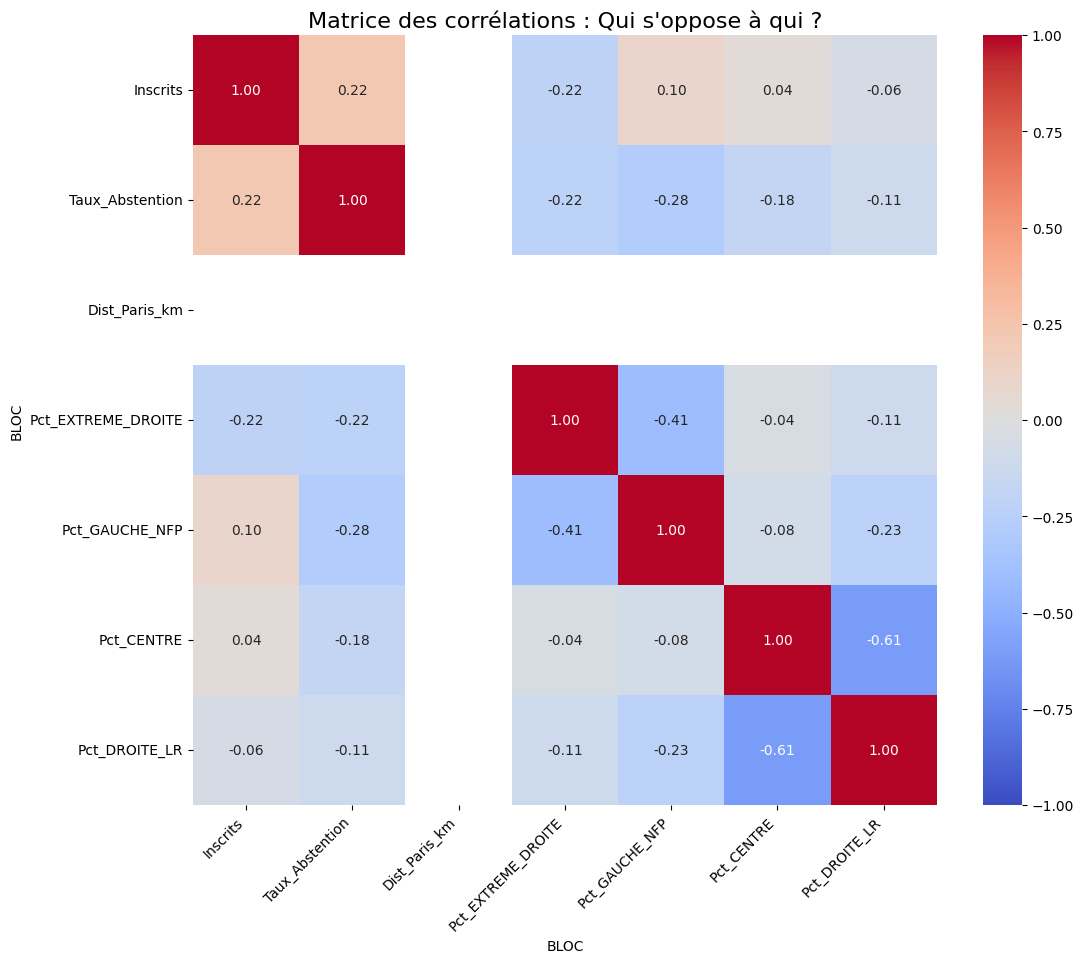


--- Aperçu des données (Avec Nom de commune !) ---
BLOC              Nom_commune  Inscrits  Pct_EXTREME_DROITE  Pct_GAUCHE_NFP
0     L'Abergement-Clémenciat       662           38.972810       12.537764
1       L'Abergement-de-Varey       228           18.421053       28.070175
2           Ambérieu-en-Bugey      8744           25.251601       20.699909
3         Ambérieux-en-Dombes      1337           36.948392       12.939417
4                     Ambléon        98           24.489796       14.285714


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CHARGEMENT ROBUSTE ---
print("1. Chargement et Nettoyage...")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

try:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

# Identification des colonnes (Gestion des accents)
try:
    col_inscrits = [c for c in df.columns if 'nscrits' in c and '%' not in c][0]
    col_blancs = [c for c in df.columns if 'lancs' in c and '%' not in c][0]
    col_abst = [c for c in df.columns if 'bstention' in c and '%' not in c][0]
    col_nom = [c for c in df.columns if 'ibell' in c and 'commune' in c][0] # La colonne qui manquait !
    col_dep = [c for c in df.columns if 'partement' in c and 'Code' in c][0]
    col_code = 'Code commune'
except:
    print("Erreur critique : Noms de colonnes introuvables.")
    raise SystemExit

# --- 2. CALCUL DE TOUS LES BLOCS POLITIQUES ---
print("2. Calcul des scores pour TOUS les partis...")

pieces = []
cols_fixes = [col_dep, col_code, col_nom, col_inscrits, col_abst, col_blancs]

for i in range(1, 40):
    col_nuance = [c for c in df.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    
    temp = df[cols_fixes + [col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Abstentions', 'Blancs', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    pieces.append(temp)

df_long = pd.concat(pieces, ignore_index=True)

# Fonction de classification élargie
def classer_parti(nuance):
    if nuance in ['RN', 'UXD', 'REC', 'DSV']: return 'EXTREME_DROITE'
    elif nuance in ['UG', 'VEC', 'FI', 'SOC', 'COM', 'ECO', 'DVG']: return 'GAUCHE_NFP'
    elif nuance in ['ENS', 'DVC', 'UDI', 'HOR', 'MDM', 'REN']: return 'CENTRE'
    elif nuance in ['LR', 'DVD']: return 'DROITE_LR'
    else: return 'AUTRE'

df_long['BLOC'] = df_long['Nuance'].apply(classer_parti)

# On pivote pour avoir une colonne par parti
df_pivot = df_long.pivot_table(
    index=['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Abstentions', 'Blancs'],
    columns='BLOC',
    values='Voix',
    aggfunc='sum'
).fillna(0).reset_index()

# Nettoyage des chiffres
for c in ['Inscrits', 'Abstentions', 'Blancs']:
    df_pivot[c] = pd.to_numeric(df_pivot[c], errors='coerce')

# --- 3. CRÉATION DES VARIABLES D'ANALYSE ---
print("3. Calcul des statistiques...")

# A. Les taux de vote (%)
for bloc in ['EXTREME_DROITE', 'GAUCHE_NFP', 'CENTRE', 'DROITE_LR']:
    df_pivot[f'Pct_{bloc}'] = (df_pivot[bloc] / df_pivot['Inscrits']) * 100

df_pivot['Taux_Abstention'] = (df_pivot['Abstentions'] / df_pivot['Inscrits']) * 100

# B. Distance à Paris (Si possible)
print("   (Tentative calcul distance Paris...)")
url_geo = "https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/download/?format=csv&use_labels_for_header=true"
try:
    df_geo = pd.read_csv(url_geo, sep=';', dtype=str, usecols=['Code INSEE', 'Geo Point'])
    gps = df_geo['Geo Point'].str.split(',', expand=True)
    df_geo['Lat'] = pd.to_numeric(gps[0])
    df_geo['Lon'] = pd.to_numeric(gps[1])
    
    # Clé de jointure
    df_pivot['Key'] = df_pivot['Code_dep'].str.zfill(2) + df_pivot['Code_commune'].str.zfill(3)
    df_final = pd.merge(df_pivot, df_geo, left_on='Key', right_on='Code INSEE', how='inner')
    
    # Distance Paris
    def dist_paris(row):
        lat_diff = (row['Lat'] - 48.8566) * 111
        lon_diff = (row['Lon'] - 2.3522) * 111 * np.cos(np.radians(48.85))
        return np.sqrt(lat_diff**2 + lon_diff**2)
    
    df_final['Dist_Paris_km'] = df_final.apply(dist_paris, axis=1)
    
except:
    print("   -> Pas de GPS, on fera sans la distance.")
    df_final = df_pivot # On garde ce qu'on a
    df_final['Dist_Paris_km'] = np.nan

# Filtre propreté
df_final = df_final[(df_final['Inscrits'] > 50) & (df_final['Inscrits'] < 200000)]

# --- 4. LA MATRICE DE CORRÉLATION (VUE D'ENSEMBLE) ---
# C'est ici qu'on voit TOUS les points de vue
cols_a_analyser = ['Inscrits', 'Taux_Abstention', 'Dist_Paris_km', 
                   'Pct_EXTREME_DROITE', 'Pct_GAUCHE_NFP', 'Pct_CENTRE', 'Pct_DROITE_LR']

# On enlève la distance si elle n'a pas été calculée
cols_a_analyser = [c for c in cols_a_analyser if c in df_final.columns]

matrice = df_final[cols_a_analyser].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(matrice, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0)
plt.title("Matrice des corrélations : Qui s'oppose à qui ?", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

# --- 5. APERÇU ---
print("\n--- Aperçu des données (Avec Nom de commune !) ---")
cols_view = ['Nom_commune', 'Inscrits', 'Pct_EXTREME_DROITE', 'Pct_GAUCHE_NFP']
print(df_final[cols_view].head())

In [ ]:
#IDF

# CELL 7 (FIX DÉFINITIF) : FUSION ROBUSTE

import pandas as pd
import numpy as np
import requests
import io

# --- 1. CHARGEMENT & PRÉPARATION ---
print("--- 1. PRÉPARATION BASE ÉLECTORALE ---")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

try:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

# Identification des colonnes
col_dep = [c for c in df.columns if 'partement' in c and 'Code' in c][0]
col_code_com = 'Code commune'  # Dans ce fichier, c'est souvent le code complet (ex: 1001)
col_nom = [c for c in df.columns if 'ibell' in c and 'commune' in c][0]
col_inscrits = [c for c in df.columns if 'nscrits' in c and '%' not in c][0]
col_abst = [c for c in df.columns if 'bstention' in c and '%' not in c][0]

# Récupération votes RN
pieces = []
for i in range(1, 40):
    col_nuance = [c for c in df.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    
    temp = df[[col_dep, col_code_com, col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_dep', 'Code_commune', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] 
    pieces.append(temp)

if pieces:
    df_rn = pd.concat(pieces, ignore_index=True)
    # On groupe par Code Commune uniquement car il est unique ici
    df_rn_sum = df_rn.groupby('Code_commune')['Voix'].sum().reset_index()
else:
    df_rn_sum = pd.DataFrame(columns=['Code_commune', 'Voix'])

# Base propre
df_base = df[[col_dep, col_code_com, col_nom, col_inscrits, col_abst]].copy()
df_base.columns = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Abstentions']
df_base['Inscrits'] = pd.to_numeric(df_base['Inscrits'], errors='coerce')
df_base['Abstentions'] = pd.to_numeric(df_base['Abstentions'], errors='coerce')

# Fusion Électorale
df_final = pd.merge(df_base, df_rn_sum, on='Code_commune', how='left').fillna(0)
df_final['Pct_RN'] = (df_final['Voix'] / df_final['Inscrits']) * 100
df_final['Taux_Abstention'] = (df_final['Abstentions'] / df_final['Inscrits']) * 100

# --- LE FIX EST ICI ---
# Le fichier contient '1001' pour l'Ain. On veut '01001'.
# On prend juste le code commune et on force 5 caractères.
df_final['Code_INSEE'] = df_final['Code_commune'].str.zfill(5)

print(f"Exemple Code généré (Election) : {df_final['Code_INSEE'].iloc[0]} (Doit être 5 chiffres)")
print(f"-> Base électorale OK : {len(df_final)} communes.")

# --- 2. TÉLÉCHARGEMENT DONNÉES SOCIO-ÉCO ---
print("\n--- 2. RÉCUPÉRATION DONNÉES SOCIO-ÉCO ---")
URL_INSEE = "https://data.iledefrance.fr/api/explore/v2.1/catalog/datasets/base-comparateur-de-territoires/exports/csv?lang=fr&timezone=Europe%2FParis&use_labels_for_header=true&csv_separator=%3B"

try:
    print("Téléchargement en cours...")
    r = requests.get(URL_INSEE)
    df_socio = pd.read_csv(io.StringIO(r.content.decode('utf-8')), sep=';', dtype=str)
    
    # Recherche intelligente des colonnes
    cols = df_socio.columns
    col_code_insee = next((c for c in cols if c.lower() in ['codgeo', 'code_insee', 'code_commune']), None)
    
    # On cherche les colonnes les plus récentes
    candidates_med = sorted([c for c in cols if c.lower().startswith('med') and len(c) < 10])
    col_revenu = candidates_med[-1] if candidates_med else None
    
    candidates_pauv = sorted([c for c in cols if c.lower().startswith('tp60')])
    col_pauvrete = candidates_pauv[-1] if candidates_pauv else None
    
    candidates_pop = sorted([c for c in cols if 'pop1564' in c.lower()])
    col_pop = candidates_pop[-1] if candidates_pop else None

    print(f"-> Colonnes détectées : Revenu='{col_revenu}', Pauvreté='{col_pauvrete}'")

    # Préparation df_eco
    if col_code_insee and col_revenu:
        df_eco = df_socio[[col_code_insee, col_revenu, col_pauvrete]].copy()
        if col_pop: df_eco[col_pop] = df_socio[col_pop]
        
        rename_dict = {col_code_insee: 'Code_INSEE', col_revenu: 'Revenu_Median', col_pauvrete: 'Taux_Pauvrete'}
        if col_pop: rename_dict[col_pop] = 'Pop_Active'
            
        df_eco = df_eco.rename(columns=rename_dict)
        
        # Nettoyage des codes INSEE (parfois '1001' devient 1001 en nombre)
        df_eco['Code_INSEE'] = df_eco['Code_INSEE'].astype(str).str.zfill(5)
        
        # Nettoyage des chiffres
        for c in ['Revenu_Median', 'Taux_Pauvrete']:
            df_eco[c] = pd.to_numeric(df_eco[c], errors='coerce')
    else:
        print("ERREUR : Colonnes vitales non trouvées dans l'API.")
        df_eco = pd.DataFrame(columns=['Code_INSEE'])

except Exception as e:
    print(f"ERREUR API : {e}")
    df_eco = pd.DataFrame(columns=['Code_INSEE'])

# --- 3. FUSION FINALE ---
print("\n--- 3. FUSION ET RÉSULTAT ---")

# Fusion (Inner Join pour voir ce qui matche)
df_modele = pd.merge(df_final, df_eco, on='Code_INSEE', how='inner')

print(f"Nombre de communes après fusion : {len(df_modele)}")
print("Aperçu des données prêtes :")
cols_view = [c for c in ['Nom_commune', 'Pct_RN', 'Revenu_Median', 'Taux_Pauvrete'] if c in df_modele.columns]
display(df_modele[cols_view].head())

--- 1. PRÉPARATION BASE ÉLECTORALE ---
Exemple Code généré (Election) : 01001 (Doit être 5 chiffres)
-> Base électorale OK : 35232 communes.

--- 2. RÉCUPÉRATION DONNÉES SOCIO-ÉCO ---
Téléchargement en cours...
-> Colonnes détectées : Revenu='med20', Pauvreté='tp6020'

--- 3. FUSION ET RÉSULTAT ---
Nombre de communes après fusion : 1266
Aperçu des données prêtes :


,Nom_commune,Pct_RN,Revenu_Median,Taux_Pauvrete
0,Achères-la-Forêt,28.391167,29170.0,NaN
1,Amillis,35.791367,24800.0,NaN
2,Amponville,30.249110,27690.0,NaN
3,Andrezel,30.357143,27420.0,NaN
4,Annet-sur-Marne,31.494662,27940.0,NaN


In [ ]:
#FranceENT

# CELL 7 (CORRIGÉE : AVEC NOM DES VILLES)
import pandas as pd
import numpy as np
import os

print("--- 1. PRÉPARATION BASE ÉLECTORALE ---")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

# Chargement robuste
try:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

# --- Identification des colonnes ---
col_code_com = 'Code commune'
# On cherche les colonnes avec des noms variables (accents etc.)
col_dep = [c for c in df.columns if 'partement' in c and 'Code' in c][0]
col_nom = [c for c in df.columns if 'ibell' in c and 'commune' in c][0]  # <--- C'est celle-ci qu'il manquait !
col_inscrits = [c for c in df.columns if 'nscrits' in c and '%' not in c][0]
col_abst = [c for c in df.columns if 'bstention' in c and '%' not in c][0]

# --- Extraction Votes RN ---
pieces = []
for i in range(1, 40):
    col_nuance = [c for c in df.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    temp = df[[col_dep, col_code_com, col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_dep', 'Code_commune', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] 
    pieces.append(temp)

if pieces:
    df_rn = pd.concat(pieces, ignore_index=True).groupby('Code_commune')['Voix'].sum().reset_index()
else:
    df_rn = pd.DataFrame(columns=['Code_commune', 'Voix'])

# --- Base électorale propre (AVEC LE NOM CETTE FOIS) ---
# On ajoute col_nom ici
df_base = df[[col_dep, col_code_com, col_nom, col_inscrits, col_abst]].copy()
df_base.columns = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Abstentions']

# Nettoyage chiffres
df_base['Inscrits'] = pd.to_numeric(df_base['Inscrits'], errors='coerce')
df_base['Abstentions'] = pd.to_numeric(df_base['Abstentions'], errors='coerce')

# Fusion
df_final = pd.merge(df_base, df_rn, on='Code_commune', how='left').fillna(0)
df_final['Pct_RN'] = (df_final['Voix'] / df_final['Inscrits']) * 100
df_final['Taux_Abstention'] = (df_final['Abstentions'] / df_final['Inscrits']) * 100
df_final['Code_INSEE'] = df_final['Code_commune'].str.zfill(5)

print(f"-> Base électorale prête : {len(df_final)} communes.")

# --- 2. TRAITEMENT INTELLIGENT DU FICHIER INSEE ---
print("\n--- 2. CALCUL DES INDICATEURS SOCIO-ÉCO ---")
FICHIER_INSEE = "base_cc_comparateur.csv"

if os.path.exists(FICHIER_INSEE):
    # Lecture
    try:
        df_socio = pd.read_csv(FICHIER_INSEE, sep=';', dtype=str)
    except:
        df_socio = pd.read_csv(FICHIER_INSEE, sep=';', dtype=str, encoding='latin-1')
    
    # Mapping des variables
    mapping = {
        'CODGEO': 'Code_INSEE',
        'MED21': 'Revenu_Median',
        'PIMP21': 'Part_Imposes',
        'P22_POP': 'Population',
        'SUPERF': 'Surface',
        'P22_CHOM1564': 'Chomeurs',
        'P22_ACT1564': 'Actifs',
        'P22_RP_PROP': 'Proprios',
        'P22_RP': 'Residences_Princ'
    }
    
    # On filtre
    cols_presentes = [c for c in mapping.keys() if c in df_socio.columns]
    df_eco = df_socio[cols_presentes].copy()
    df_eco = df_eco.rename(columns=mapping)
    
    # Conversion Numérique (Gestion virgules)
    for c in df_eco.columns:
        if c != 'Code_INSEE':
            df_eco[c] = df_eco[c].astype(str).str.replace(',', '.', regex=False)
            df_eco[c] = pd.to_numeric(df_eco[c], errors='coerce')

    # --- CRÉATION DES VARIABLES ---
    if 'Population' in df_eco.columns and 'Surface' in df_eco.columns:
        df_eco['Densite'] = df_eco['Population'] / df_eco['Surface']
    
    if 'Chomeurs' in df_eco.columns and 'Actifs' in df_eco.columns:
        df_eco['Taux_Chomage'] = (df_eco['Chomeurs'] / df_eco['Actifs']) * 100
        
    if 'Proprios' in df_eco.columns and 'Residences_Princ' in df_eco.columns:
        df_eco['Taux_Proprietaires'] = (df_eco['Proprios'] / df_eco['Residences_Princ']) * 100

    df_eco['Code_INSEE'] = df_eco['Code_INSEE'].str.zfill(5)
    print("-> Indicateurs calculés.")
    
else:
    print("ERREUR : Fichier INSEE introuvable.")
    df_eco = pd.DataFrame(columns=['Code_INSEE'])

# --- 3. FUSION FINALE ---
print("\n--- 3. FUSION ---")
df_modele = pd.merge(df_final, df_eco, on='Code_INSEE', how='inner')

print(f"Nombre de communes dans le modèle : {len(df_modele)}")

# Affichage de vérification (AVEC LE NOM)
cols_view = ['Nom_commune', 'Pct_RN', 'Revenu_Median', 'Densite', 'Taux_Chomage', 'Taux_Proprietaires']
cols_final = [c for c in cols_view if c in df_modele.columns]
display(df_modele[cols_final].head())

--- 1. PRÉPARATION BASE ÉLECTORALE ---
-> Base électorale prête : 35232 communes.

--- 2. CALCUL DES INDICATEURS SOCIO-ÉCO ---
-> Indicateurs calculés.

--- 3. FUSION ---
Nombre de communes dans le modèle : 34929


,Nom_commune,Pct_RN,Revenu_Median,Densite,Taux_Chomage,Taux_Proprietaires
0,L'Abergement-Clémenciat,38.972810,25820.0,53.855799,6.496520,85.593220
1,L'Abergement-de-Varey,18.421053,24480.0,29.836066,1.503759,87.603306
2,Ambérieu-en-Bugey,25.251601,21660.0,632.276423,13.446503,45.062188
3,Ambérieux-en-Dombes,36.948392,24610.0,120.414573,6.335778,72.965300
4,Ambléon,24.489796,24210.0,19.387755,9.803922,71.929825


In [9]:
# CELL 7 (VERSION ULTIME : 6 INDICATEURS SOCIO-ÉCO)
import pandas as pd
import numpy as np
import os

print("--- 1. PRÉPARATION BASE ÉLECTORALE ---")
FILE_PATH = 'resultats-definitifs-par-communes.csv'

# Chargement
try:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='utf-8', dtype=str)
except:
    df = pd.read_csv(FILE_PATH, sep=';', encoding='latin-1', dtype=str)

col_dep = [c for c in df.columns if 'partement' in c and 'Code' in c][0]
col_code_com = 'Code commune'
col_nom = [c for c in df.columns if 'ibell' in c and 'commune' in c][0]
col_inscrits = [c for c in df.columns if 'nscrits' in c and '%' not in c][0]
col_abst = [c for c in df.columns if 'bstention' in c and '%' not in c][0]

# Votes RN
pieces = []
for i in range(1, 40):
    col_nuance = [c for c in df.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    temp = df[[col_dep, col_code_com, col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_dep', 'Code_commune', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] 
    pieces.append(temp)

if pieces:
    df_rn = pd.concat(pieces, ignore_index=True).groupby('Code_commune')['Voix'].sum().reset_index()
else:
    df_rn = pd.DataFrame(columns=['Code_commune', 'Voix'])

# Base propre
df_base = df[[col_dep, col_code_com, col_nom, col_inscrits, col_abst]].copy()
df_base.columns = ['Code_dep', 'Code_commune', 'Nom_commune', 'Inscrits', 'Abstentions']
df_base['Inscrits'] = pd.to_numeric(df_base['Inscrits'], errors='coerce')
df_base['Abstentions'] = pd.to_numeric(df_base['Abstentions'], errors='coerce')

df_final = pd.merge(df_base, df_rn, on='Code_commune', how='left').fillna(0)
df_final['Pct_RN'] = (df_final['Voix'] / df_final['Inscrits']) * 100
df_final['Taux_Abstention'] = (df_final['Abstentions'] / df_final['Inscrits']) * 100
df_final['Code_INSEE'] = df_final['Code_commune'].str.zfill(5)
print(f"-> Base électorale prête : {len(df_final)} communes.")

# --- 2. INDICATEURS COMPLETS (FICHIER LOCAL) ---
print("\n--- 2. CALCUL DES 6 INDICATEURS CLÉS ---")
FICHIER_INSEE = "base_cc_comparateur.csv"

if os.path.exists(FICHIER_INSEE):
    try:
        df_socio = pd.read_csv(FICHIER_INSEE, sep=';', dtype=str)
    except:
        df_socio = pd.read_csv(FICHIER_INSEE, sep=';', dtype=str, encoding='latin-1')

    # Mapping complet
    mapping = {
        'CODGEO': 'Code_INSEE',
        'MED21': 'Revenu_Median',
        'PIMP21': 'Part_Imposes',     # NOUVEAU : % foyers imposés
        'P22_POP': 'Population',
        'SUPERF': 'Surface',
        'P22_CHOM1564': 'Chomeurs',
        'P22_ACT1564': 'Actifs',
        'P22_RP_PROP': 'Proprios',
        'P22_RP': 'Residences_Princ',
        'P22_LOGVAC': 'Logements_Vacants', # NOUVEAU : Logements vides
        'P22_LOG': 'Total_Logements'       # NOUVEAU : Pour calculer le %
    }
    
    cols_presentes = [c for c in mapping.keys() if c in df_socio.columns]
    df_eco = df_socio[cols_presentes].copy()
    df_eco = df_eco.rename(columns=mapping)
    
    # Nettoyage numérique
    for c in df_eco.columns:
        if c != 'Code_INSEE':
            df_eco[c] = df_eco[c].astype(str).str.replace(',', '.', regex=False)
            df_eco[c] = pd.to_numeric(df_eco[c], errors='coerce')

    # Calcul des ratios
    if 'Population' in df_eco.columns and 'Surface' in df_eco.columns:
        df_eco['Densite'] = df_eco['Population'] / df_eco['Surface']
    
    if 'Chomeurs' in df_eco.columns and 'Actifs' in df_eco.columns:
        df_eco['Taux_Chomage'] = (df_eco['Chomeurs'] / df_eco['Actifs']) * 100
        
    if 'Proprios' in df_eco.columns and 'Residences_Princ' in df_eco.columns:
        df_eco['Taux_Proprietaires'] = (df_eco['Proprios'] / df_eco['Residences_Princ']) * 100
        
    if 'Logements_Vacants' in df_eco.columns and 'Total_Logements' in df_eco.columns:
        df_eco['Taux_Vacance'] = (df_eco['Logements_Vacants'] / df_eco['Total_Logements']) * 100

    df_eco['Code_INSEE'] = df_eco['Code_INSEE'].str.zfill(5)
    print("-> Indicateurs calculés : Revenu, Densité, Chômage, Propriétaires, Imposés, Logements Vacants.")

else:
    print("ERREUR : Fichier INSEE introuvable.")
    df_eco = pd.DataFrame(columns=['Code_INSEE'])

# --- 3. FUSION ---
print("\n--- 3. FUSION ---")
df_modele = pd.merge(df_final, df_eco, on='Code_INSEE', how='inner')

print(f"Nombre de communes dans le modèle : {len(df_modele)}")
cols_view = ['Nom_commune', 'Pct_RN', 'Revenu_Median', 'Part_Imposes', 'Taux_Vacance']
cols_final = [c for c in cols_view if c in df_modele.columns]
display(df_modele[cols_final].head())

--- 1. PRÉPARATION BASE ÉLECTORALE ---
-> Base électorale prête : 35232 communes.

--- 2. CALCUL DES 6 INDICATEURS CLÉS ---
-> Indicateurs calculés : Revenu, Densité, Chômage, Propriétaires, Imposés, Logements Vacants.

--- 3. FUSION ---
Nombre de communes dans le modèle : 34929


,Nom_commune,Pct_RN,Revenu_Median,Part_Imposes,Taux_Vacance
0,L'Abergement-Clémenciat,38.972810,25820.0,NaN,3.693931
1,L'Abergement-de-Varey,18.421053,24480.0,NaN,7.428571
2,Ambérieu-en-Bugey,25.251601,21660.0,50.0,9.296133
3,Ambérieux-en-Dombes,36.948392,24610.0,61.0,10.699249
4,Ambléon,24.489796,24210.0,NaN,8.450704


--- 1. SÉLECTION DES VARIABLES ---
Variables du modèle : ['Inscrits', 'Taux_Chomage', 'Revenu_Median', 'Densite', 'Part_Imposes', 'Taux_Proprietaires', 'Taux_Vacance', 'Taux_Abstention']

--- RÉSULTATS DE LA RÉGRESSION ---
Fiabilité du modèle (R²) : 7.22%

>>> IMPACT SUR LE VOTE RN (Coefficients) :
(Positif = Fait monter le RN / Négatif = Fait baisser le RN)


,Label,Coef
4,Propriétaires,1.350093
5,Logements Vides,0.314510
0,Chômage,-0.246971
1,Niveau de Vie (Richesse),-0.431162
3,Part Ménages Imposés,-0.460675
7,Population (Taille de la ville),-0.612734
2,Densité (Campagne),-0.657895
6,Abstention,-0.669572


/tmp/ipykernel_73250/1231846973.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Importance', y='Label', palette='coolwarm')


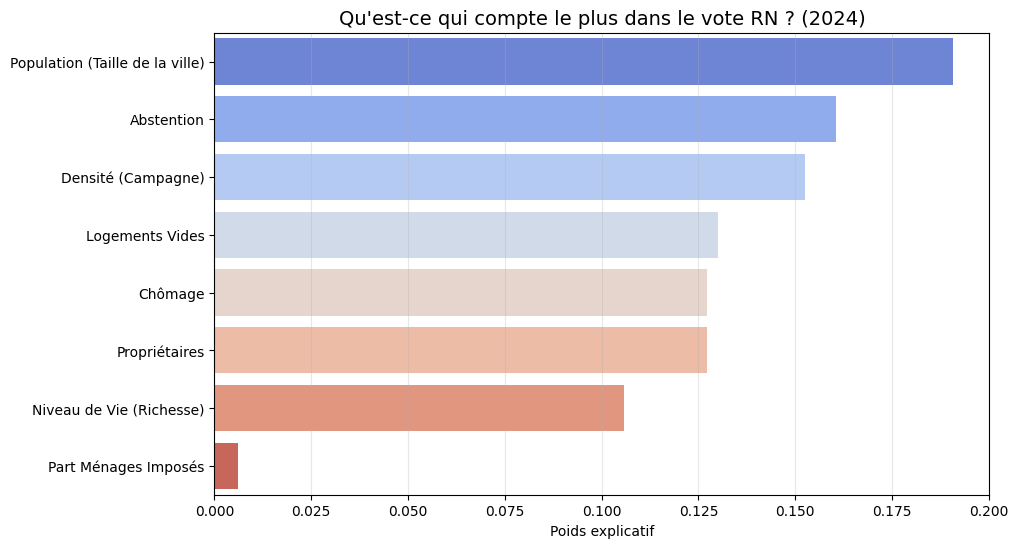


>>> CONCLUSION SUR TES VARIABLES CLÉS :
- Population : Quand ça augmente, le vote RN a tendance à BAISSER.
- Niveau de Vie : Quand ça augmente, le vote RN a tendance à BAISSER.
- Chômage : Quand ça augmente, le vote RN a tendance à BAISSER.


In [12]:
# CELL 8 : MODÉLISATION FINALE (POPULATION + CHÔMAGE + NIVEAU DE VIE)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("--- 1. SÉLECTION DES VARIABLES ---")

# On définit explicitement les variables clés que tu as demandées
features_prioritaires = ['Inscrits', 'Taux_Chomage', 'Revenu_Median']
# On ajoute les variables de contexte (utiles pour la précision)
features_secondaires = ['Densite', 'Part_Imposes', 'Taux_Proprietaires', 'Taux_Vacance', 'Taux_Abstention']

# On construit la liste finale en vérifiant ce qui existe dans le tableau
all_features = features_prioritaires + features_secondaires
features_dispo = [c for c in all_features if c in df_modele.columns]
target = 'Pct_RN'

print(f"Variables du modèle : {features_dispo}")

# --- 2. PRÉPARATION ---
# Nettoyage des lignes vides
data_ml = df_modele.dropna(subset=[target]).copy()

# Remplissage des trous éventuels (médiane)
imputer = SimpleImputer(strategy='median')
X = data_ml[features_dispo]
X_filled = pd.DataFrame(imputer.fit_transform(X), columns=features_dispo)
y = data_ml[target]

# --- TRANSFORMATION LOGARITHMIQUE (Population) ---
# Pour que la régression marche mathématiquement, on doit "aplatir" les écarts de population
# (Sinon Paris écrase tout). On crée 'Log_Population' mais c'est bien la taille qui est mesurée.
if 'Inscrits' in X_filled.columns:
    X_filled['Log_Population'] = np.log1p(X_filled['Inscrits'])
    X_filled = X_filled.drop(columns=['Inscrits'])

# Mise à jour des noms de colonnes pour l'affichage
feature_names = X_filled.columns.tolist()

# Split (80% Apprentissage / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.2, random_state=42)

# Standardisation (Mettre tout sur une échelle comparable pour voir qui a le plus d'impact)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- 3. RÉGRESSION LINÉAIRE (IMPACT +/-) ---
print("\n--- RÉSULTATS DE LA RÉGRESSION ---")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
r2 = lr.score(X_test_scaled, y_test)

print(f"Fiabilité du modèle (R²) : {r2:.2%}")
print("\n>>> IMPACT SUR LE VOTE RN (Coefficients) :")
print("(Positif = Fait monter le RN / Négatif = Fait baisser le RN)")

coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coef': lr.coef_
}).sort_values('Coef', ascending=False)

# Affichage personnalisé
labels_map = {
    'Log_Population': 'Population (Taille de la ville)',
    'Revenu_Median': 'Niveau de Vie (Richesse)',
    'Taux_Chomage': 'Chômage',
    'Part_Imposes': 'Part Ménages Imposés',
    'Densite': 'Densité (Campagne)',
    'Taux_Proprietaires': 'Propriétaires',
    'Taux_Vacance': 'Logements Vides',
    'Taux_Abstention': 'Abstention'
}
coefs['Label'] = coefs['Variable'].map(labels_map).fillna(coefs['Variable'])

# On affiche le tableau proprement
display(coefs[['Label', 'Coef']])


# --- 4. GRAPHIQUE DE SYNTHÈSE (Random Forest) ---
# Le Random Forest permet de classer l'importance réelle (y compris les liens non-linéaires)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importance = pd.DataFrame({
    'Variable': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
importance['Label'] = importance['Variable'].map(labels_map).fillna(importance['Variable'])

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='Importance', y='Label', palette='coolwarm')
plt.title("Qu'est-ce qui compte le plus dans le vote RN ? (2024)", fontsize=14)
plt.xlabel("Poids explicatif")
plt.ylabel("")
plt.grid(axis='x', alpha=0.3)
plt.show()

# --- 5. INTERPRÉTATION AUTOMATIQUE ---
# On cherche tes 3 variables clés dans les résultats
def analyse_variable(nom_tech, nom_humain):
    if nom_tech in coefs['Variable'].values:
        val = coefs[coefs['Variable']==nom_tech]['Coef'].values[0]
        effet = "MONTER" if val > 0 else "BAISSER"
        print(f"- {nom_humain} : Quand ça augmente, le vote RN a tendance à {effet}.")

print("\n>>> CONCLUSION SUR TES VARIABLES CLÉS :")
analyse_variable('Log_Population', 'Population')
analyse_variable('Revenu_Median', 'Niveau de Vie')
analyse_variable('Taux_Chomage', 'Chômage')

--- 1. CRÉATION DU MODÈLE SOCIO-ÉCONOMIQUE PUR ---
Variables utilisées : ['Inscrits', 'Revenu_Median', 'Taux_Chomage']

--- RÉSULTATS RÉGRESSION LINÉAIRE ---
Le modèle explique 8.0% des variations du vote avec seulement ces 3 critères.

>>> IMPACT SUR LE VOTE RN :
- Taux de Chômage : FAIT BAISSER le RN (Force de l'impact: 0.14)
- Niveau de Vie (Richesse) : FAIT BAISSER le RN (Force de l'impact: 0.17)
- Taille de la Ville (Population) : FAIT BAISSER le RN (Force de l'impact: 2.22)


/tmp/ipykernel_73250/3305883362.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Importance', y='Label', palette='Reds_r')


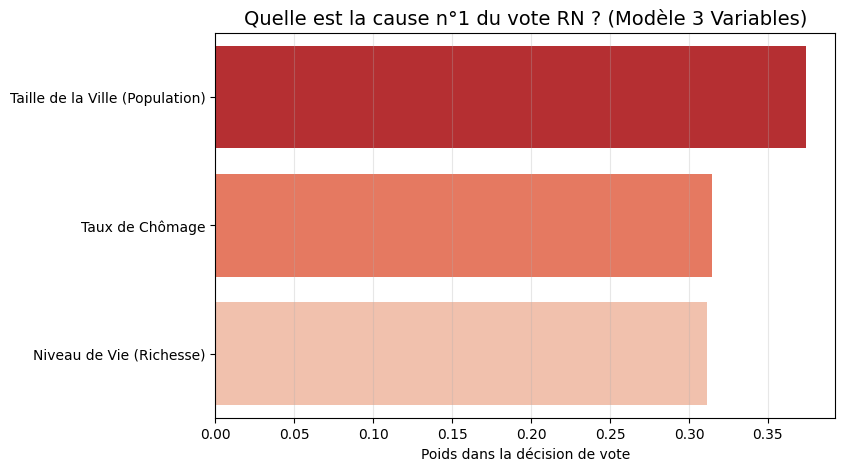


>>> CONCLUSION FINALE :
Sur tes 3 critères, c'est le critère 'Taille de la Ville (Population)' qui joue le plus.
C'est une corrélation NÉGATIVE : Plus il y a de 'Taille de la Ville (Population)', MOINS on vote RN.


In [13]:
# CELL 8 : MODÉLISATION STRICTE (Population, Chômage, Revenu)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("--- 1. CRÉATION DU MODÈLE SOCIO-ÉCONOMIQUE PUR ---")

# On respecte ta demande à la lettre : 3 variables uniquement
features_cible = ['Inscrits', 'Revenu_Median', 'Taux_Chomage']
target = 'Pct_RN'

# Vérification que les colonnes existent
features_dispo = [c for c in features_cible if c in df_modele.columns]
print(f"Variables utilisées : {features_dispo}")

if len(features_dispo) < 3:
    print("ATTENTION : Il manque des variables (vérifie la Cellule 7).")

# Nettoyage
data_ml = df_modele.dropna(subset=[target] + features_dispo).copy()
X = data_ml[features_dispo]
y = data_ml[target]

# --- TRANSFORMATION LOGARITHMIQUE (Population) ---
# Indispensable : On transforme la population en "Log" pour que la comparaison 
# entre Paris (2M hab) et un village (100 hab) soit mathématiquement juste.
if 'Inscrits' in X.columns:
    X = X.copy() # Pour éviter le warning
    X['Log_Population'] = np.log1p(X['Inscrits'])
    X = X.drop(columns=['Inscrits'])

feature_names = X.columns.tolist()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation (Mettre Revenus et % Chômage sur la même échelle)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- 2. RÉGRESSION LINÉAIRE (SENS DE L'IMPACT) ---
print("\n--- RÉSULTATS RÉGRESSION LINÉAIRE ---")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
r2 = lr.score(X_test_scaled, y_test)

print(f"Le modèle explique {r2:.1%} des variations du vote avec seulement ces 3 critères.")
print("\n>>> IMPACT SUR LE VOTE RN :")

coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coef': lr.coef_
}).sort_values('Coef', ascending=False)

labels_map = {
    'Log_Population': 'Taille de la Ville (Population)',
    'Revenu_Median': 'Niveau de Vie (Richesse)',
    'Taux_Chomage': 'Taux de Chômage'
}
coefs['Label'] = coefs['Variable'].map(labels_map).fillna(coefs['Variable'])

for index, row in coefs.iterrows():
    impact = "FAIT MONTER" if row['Coef'] > 0 else "FAIT BAISSER"
    force = abs(row['Coef'])
    print(f"- {row['Label']} : {impact} le RN (Force de l'impact: {force:.2f})")


# --- 3. GRAPHIQUE D'IMPORTANCE (Random Forest) ---
# Le Random Forest permet de voir quelle variable est la "Chef"
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importance = pd.DataFrame({
    'Variable': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
importance['Label'] = importance['Variable'].map(labels_map).fillna(importance['Variable'])

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Label', palette='Reds_r')
plt.title("Quelle est la cause n°1 du vote RN ? (Modèle 3 Variables)", fontsize=14)
plt.xlabel("Poids dans la décision de vote")
plt.ylabel("")
plt.grid(axis='x', alpha=0.3)
plt.show()

# --- 4. CONCLUSION AUTOMATIQUE ---
top1 = importance.iloc[0]['Label']
top1_tech = importance.iloc[0]['Variable']
sens = "inverse" if coefs[coefs['Variable']==top1_tech]['Coef'].values[0] < 0 else "proportionnel"

print(f"\n>>> CONCLUSION FINALE :")
print(f"Sur tes 3 critères, c'est le critère '{top1}' qui joue le plus.")
if sens == "inverse":
    print(f"C'est une corrélation NÉGATIVE : Plus il y a de '{top1}', MOINS on vote RN.")
else:
    print(f"C'est une corrélation POSITIVE : Plus il y a de '{top1}', PLUS on vote RN.")

--- 1. CHARGEMENT DONNÉES ÉLECTORALES ---


Base électorale : 35232 communes.

--- 2. APPEL API GÉO (Distance & Densité) ---
Appel de https://geo.api.gouv.fr/communes?fields=code,centre,surface,population&format=json&geometry=centre...
-> SUCCÈS : Variables 'Dist_Paris' et 'Densite_Reelle' ajoutées.

--- 3. APPEL API CAF (Précarité RSA) ---
Tentative téléchargement CAF...
-> ECHEC Téléchargement CAF (Code 404)

--- 4. MODÉLISATION DYNAMIQUE ---
Variables disponibles pour le modèle : ['Inscrits', 'Dist_Paris', 'Densite_Reelle']
>>> PERFORMANCE DU MODÈLE (R²) : 27.34%


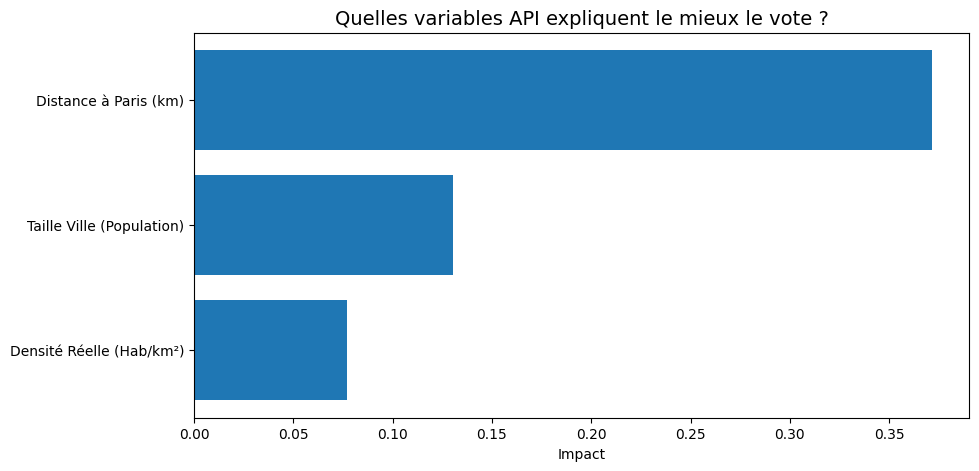

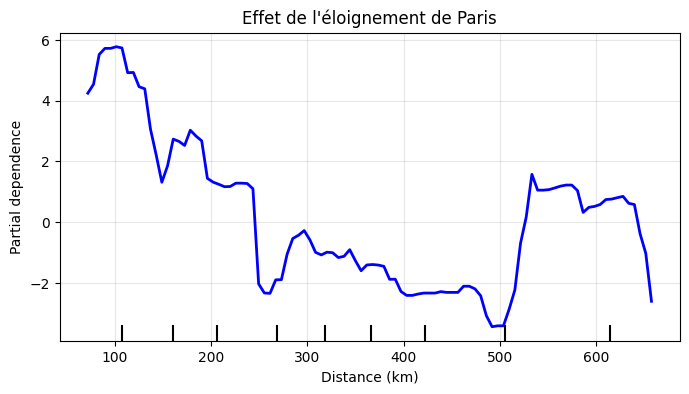

In [9]:
# CELL 10 : VARIABLES API ROBUSTES (Géo, Densité, RSA) & MODÉLISATION
import pandas as pd
import numpy as np
import requests
import io
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt

print("--- 1. CHARGEMENT DONNÉES ÉLECTORALES ---")
try:
    df_elec = pd.read_csv('resultats-definitifs-par-communes.csv', sep=';', encoding='utf-8', dtype=str)
except:
    df_elec = pd.read_csv('resultats-definitifs-par-communes.csv', sep=';', encoding='latin-1', dtype=str)

# Préparation standard
col_code = 'Code commune'
col_inscrits = [c for c in df_elec.columns if 'nscrits' in c and '%' not in c][0]

# Extraction Votes RN
pieces = []
for i in range(1, 40):
    col_nuance = [c for c in df_elec.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df_elec.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    temp = df_elec[[col_code, col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_commune', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] 
    pieces.append(temp)

if pieces:
    df_rn = pd.concat(pieces, ignore_index=True).groupby('Code_commune')['Voix'].sum().reset_index()
else:
    df_rn = pd.DataFrame(columns=['Code_commune', 'Voix'])

df_final = df_elec[[col_code, col_inscrits]].copy()
df_final.columns = ['Code_commune', 'Inscrits']
df_final['Inscrits'] = pd.to_numeric(df_final['Inscrits'], errors='coerce')
df_final = pd.merge(df_final, df_rn, on='Code_commune', how='left').fillna(0)
df_final['Pct_RN'] = (df_final['Voix'] / df_final['Inscrits']) * 100
df_final['Code_INSEE'] = df_final['Code_commune'].str.zfill(5)
print(f"Base électorale : {len(df_final)} communes.")
df_modele = df_final.copy()


print("\n--- 2. APPEL API GÉO (Distance & Densité) ---")
# On demande : le code, les coordonnées (centre), la surface et la population
url_geo = "https://geo.api.gouv.fr/communes?fields=code,centre,surface,population&format=json&geometry=centre"

try:
    print(f"Appel de {url_geo}...")
    r_geo = requests.get(url_geo)
    if r_geo.status_code == 200:
        data_geo = r_geo.json()
        df_geo = pd.DataFrame(data_geo)
        
        # 1. Calcul Distance Paris
        # Extraction Lat/Lon
        df_geo['Lon'] = df_geo['centre'].apply(lambda x: x['coordinates'][0] if x else None)
        df_geo['Lat'] = df_geo['centre'].apply(lambda x: x['coordinates'][1] if x else None)
        
        # Paris : 48.8566, 2.3522
        def dist_paris(row):
            if pd.isna(row['Lat']): return np.nan
            lat_diff = (row['Lat'] - 48.8566) * 111
            lon_diff = (row['Lon'] - 2.3522) * 111 * np.cos(np.radians(48.85))
            return np.sqrt(lat_diff**2 + lon_diff**2)
        
        df_geo['Dist_Paris'] = df_geo.apply(dist_paris, axis=1)
        
        # 2. Calcul Densité Réelle (Habitants / Surface en km2)
        # L'API renvoie la surface en hectares -> on divise par 100 pour avoir des km2
        # L'API renvoie la population officielle -> mieux que 'Inscrits'
        df_geo['Surface_km2'] = df_geo['surface'] / 100
        df_geo['Densite_Reelle'] = df_geo['population'] / df_geo['Surface_km2']
        
        df_geo = df_geo.rename(columns={'code': 'Code_INSEE'})
        
        # Fusion
        cols_to_add = ['Code_INSEE', 'Dist_Paris', 'Densite_Reelle']
        df_modele = pd.merge(df_modele, df_geo[cols_to_add], on='Code_INSEE', how='inner')
        print("-> SUCCÈS : Variables 'Dist_Paris' et 'Densite_Reelle' ajoutées.")
    else:
        print("-> ECHEC API Géo (Statut != 200)")

except Exception as e:
    print(f"-> ERREUR API Géo : {e}")


print("\n--- 3. APPEL API CAF (Précarité RSA) ---")
# URL de téléchargement direct CSV
url_caf = "https://data.caf.fr/api/explore/v2.1/catalog/datasets/foyers-allocataires-percevant-le-revenu-de-solidarite-active-rsa-par-commune/exports/csv?lang=fr&timezone=Europe%2FParis&use_labels_for_header=true&csv_separator=%3B"

try:
    print("Tentative téléchargement CAF...")
    r_caf = requests.get(url_caf)
    if r_caf.status_code == 200:
        # Lecture
        df_caf = pd.read_csv(io.StringIO(r_caf.content.decode('utf-8')), sep=';', dtype=str)
        
        # Recherche colonnes intelligente
        cols = df_caf.columns
        col_code_caf = next((c for c in cols if 'ode' in c and 'ommune' in c), None)
        col_rsa = next((c for c in cols if 'Foyers' in c and 'RSA' in c), None)
        
        if col_code_caf and col_rsa:
            df_caf = df_caf[[col_code_caf, col_rsa]].copy()
            df_caf.columns = ['Code_INSEE', 'Nb_RSA']
            df_caf['Code_INSEE'] = df_caf['Code_INSEE'].str.zfill(5)
            df_caf['Nb_RSA'] = pd.to_numeric(df_caf['Nb_RSA'], errors='coerce').fillna(0)
            
            # Fusion
            df_modele = pd.merge(df_modele, df_caf, on='Code_INSEE', how='left')
            
            # Calcul Taux
            df_modele['Nb_RSA'] = df_modele['Nb_RSA'].fillna(0)
            df_modele['Taux_RSA'] = (df_modele['Nb_RSA'] / df_modele['Inscrits']) * 100
            print("-> SUCCÈS : Variable 'Taux_RSA' ajoutée.")
        else:
            print("-> ECHEC Lecture colonnes CAF (Format inattendu).")
    else:
        print(f"-> ECHEC Téléchargement CAF (Code {r_caf.status_code})")
        
except Exception as e:
    print(f"-> ERREUR API CAF : {e}")


print("\n--- 4. MODÉLISATION DYNAMIQUE ---")

# Liste des variables souhaitées
potential_features = {
    'Inscrits': 'Taille Ville (Population)', 
    'Dist_Paris': 'Distance à Paris (km)', 
    'Densite_Reelle': 'Densité Réelle (Hab/km²)',
    'Taux_RSA': 'Précarité (Taux RSA)'
}

# On ne garde que celles qui ont réussi à charger !
final_features = [f for f in potential_features.keys() if f in df_modele.columns]
target = 'Pct_RN'

print(f"Variables disponibles pour le modèle : {final_features}")

if len(final_features) > 0:
    # Préparation
    data = df_modele.dropna(subset=final_features + [target])
    X = data[final_features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle
    model = HistGradientBoostingRegressor(max_iter=100, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f">>> PERFORMANCE DU MODÈLE (R²) : {score:.2%}")

    # Graphique Importance
    res = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    idx = res.importances_mean.argsort()

    plt.figure(figsize=(10, 5))
    labels_graph = [potential_features[final_features[i]] for i in idx]
    plt.barh(range(len(idx)), res.importances_mean[idx], color='#1f77b4')
    plt.yticks(range(len(idx)), labels_graph)
    plt.title("Quelles variables API expliquent le mieux le vote ?", fontsize=14)
    plt.xlabel("Impact")
    plt.show()

    # Focus Distance Paris (Si dispo)
    if 'Dist_Paris' in final_features:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title("Effet de l'éloignement de Paris", fontsize=12)
        PartialDependenceDisplay.from_estimator(
            model, X_train, ['Dist_Paris'], kind="average", ax=ax,
            line_kw={"color": "blue", "linewidth": 2}
        )
        plt.xlabel("Distance (km)")
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("ERREUR : Aucune variable explicative n'a pu être chargée. Vérifiez votre connexion internet.")

--- 1. CHARGEMENT DES DONNÉES ---


-> Votes chargés : 35232 communes.
Chargement des indicateurs sociaux (INSEE Local)...
-> Analyse prête sur 34929 communes.

--- 2. ANALYSE GRAPHIQUE (RÉGRESSIONS) ---


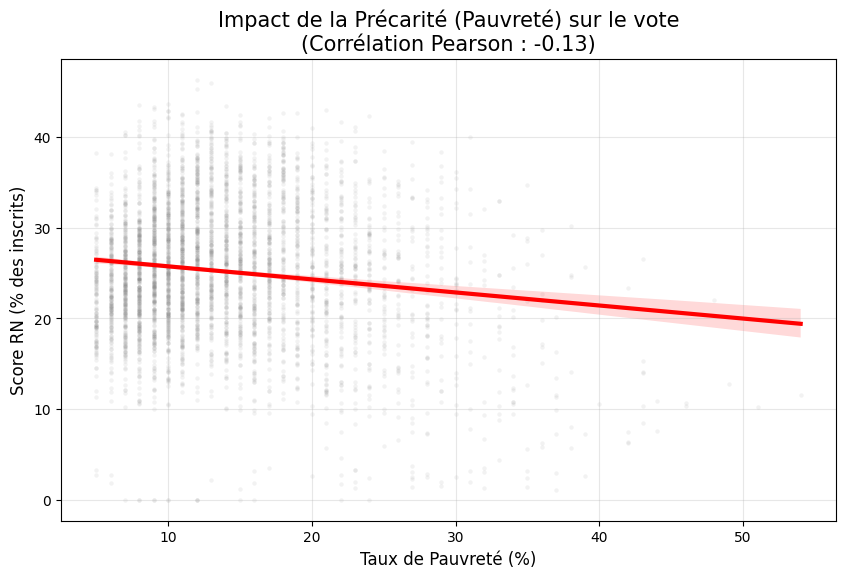

>>> INTERPRÉTATION (Taux de Pauvreté (%)) :
Pas de lien évident (Courbe plate).
--------------------------------------------------


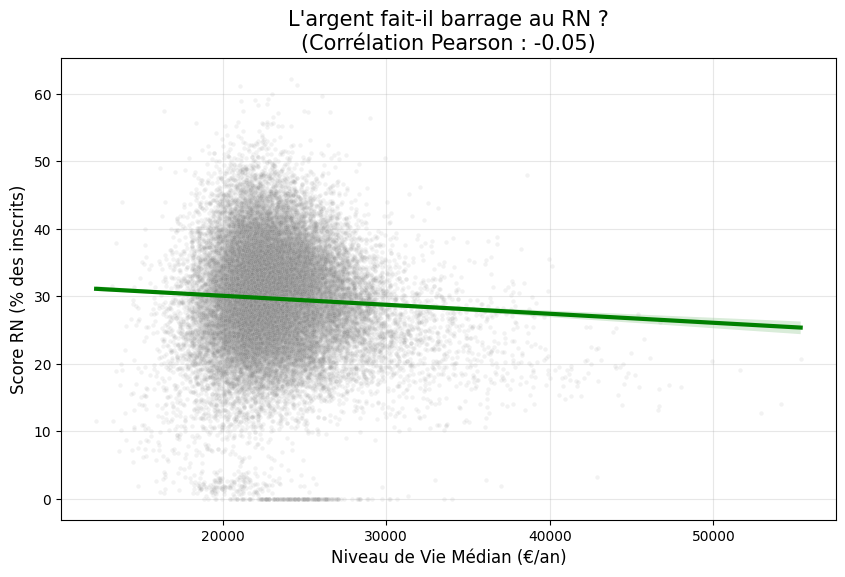

>>> INTERPRÉTATION (Niveau de Vie Médian (€/an)) :
Pas de lien évident (Courbe plate).
--------------------------------------------------


In [12]:
# CELL 10 : ANALYSE GRAPHIQUE (PAUVRETÉ & REVENUS) - VERSION ROBUSTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

print("--- 1. CHARGEMENT DES DONNÉES ---")

# A. CHARGEMENT VOTES
try:
    df_elec = pd.read_csv('resultats-definitifs-par-communes.csv', sep=';', encoding='utf-8', dtype=str)
except:
    df_elec = pd.read_csv('resultats-definitifs-par-communes.csv', sep=';', encoding='latin-1', dtype=str)

# Préparation RN
col_code = 'Code commune'
col_inscrits = [c for c in df_elec.columns if 'nscrits' in c and '%' not in c][0]

pieces = []
for i in range(1, 40):
    col_nuance = [c for c in df_elec.columns if f'Nuance candidat {i}' in c]
    col_voix = [c for c in df_elec.columns if f'Voix {i}' in c]
    if not col_nuance or not col_voix: break
    temp = df_elec[[col_code, col_nuance[0], col_voix[0]]].copy()
    temp.columns = ['Code_commune', 'Nuance', 'Voix']
    temp['Voix'] = pd.to_numeric(temp['Voix'], errors='coerce').fillna(0)
    temp = temp[temp['Nuance'].isin(['RN', 'UXD', 'REC', 'DSV'])] 
    pieces.append(temp)

if pieces:
    df_rn = pd.concat(pieces, ignore_index=True).groupby('Code_commune')['Voix'].sum().reset_index()
else:
    df_rn = pd.DataFrame(columns=['Code_commune', 'Voix'])

df_final = df_elec[[col_code, col_inscrits]].copy()
df_final.columns = ['Code_commune', 'Inscrits']
df_final['Inscrits'] = pd.to_numeric(df_final['Inscrits'], errors='coerce')
df_final = pd.merge(df_final, df_rn, on='Code_commune', how='left').fillna(0)
df_final['Pct_RN'] = (df_final['Voix'] / df_final['Inscrits']) * 100
df_final['Code_INSEE'] = df_final['Code_commune'].str.zfill(5)
print(f"-> Votes chargés : {len(df_final)} communes.")

# B. CHARGEMENT SOCIO-ECO (FICHIER LOCAL)
print("Chargement des indicateurs sociaux (INSEE Local)...")
try:
    df_insee = pd.read_csv('base_cc_comparateur.csv', sep=';', dtype=str)
except:
    df_insee = pd.read_csv('base_cc_comparateur.csv', sep=';', dtype=str, encoding='latin-1')

# Extraction Pauvreté (TP6021) et Revenus (MED21)
# On adapte les noms si besoin
cols_map = {
    'CODGEO': 'Code_INSEE',
    'TP6021': 'Taux_Pauvrete',   # C'est la variable "CAF/Précarité"
    'MED21': 'Revenu_Median'
}

# On filtre les colonnes existantes
cols_existantes = [c for c in cols_map.keys() if c in df_insee.columns]
df_eco = df_insee[cols_existantes].rename(columns=cols_map).copy()

# Nettoyage numérique (virgules -> points)
for c in df_eco.columns:
    if c != 'Code_INSEE':
        df_eco[c] = pd.to_numeric(df_eco[c].str.replace(',', '.'), errors='coerce')

df_eco['Code_INSEE'] = df_eco['Code_INSEE'].str.zfill(5)

# FUSION
df_plot = pd.merge(df_final, df_eco, on='Code_INSEE', how='inner')
print(f"-> Analyse prête sur {len(df_plot)} communes.")


print("\n--- 2. ANALYSE GRAPHIQUE (RÉGRESSIONS) ---")

def tracer_graphe(data, x_col, y_col, titre, xlabel, couleur):
    # On nettoie les NaN (villes sans données)
    subset = data.dropna(subset=[x_col, y_col])
    
    # Calcul Corrélation
    corr, _ = pearsonr(subset[x_col], subset[y_col])
    
    plt.figure(figsize=(10, 6))
    
    # Nuage de points (léger pour voir la masse)
    sns.scatterplot(data=subset, x=x_col, y=y_col, alpha=0.1, color='grey', s=10)
    
    # Courbe de tendance (La régression linéaire visuelle)
    sns.regplot(data=subset, x=x_col, y=y_col, scatter=False, color=couleur, line_kws={"linewidth": 3})
    
    plt.title(f"{titre}\n(Corrélation Pearson : {corr:.2f})", fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Score RN (% des inscrits)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f">>> INTERPRÉTATION ({xlabel}) :")
    if corr > 0.3:
        print(f"Corrélation POSITIVE FORTE : La courbe monte. Plus il y a de {xlabel}, plus le RN est fort.")
    elif corr > 0:
        print(f"Corrélation POSITIVE FAIBLE : Tendance légère à la hausse.")
    elif corr < -0.3:
        print(f"Corrélation NÉGATIVE FORTE : La courbe descend. Le {xlabel} est un rempart contre le RN.")
    else:
        print(f"Pas de lien évident (Courbe plate).")
    print("-" * 50)

# --- GRAPHE 1 : PAUVRETÉ (L'équivalent CAF) ---
if 'Taux_Pauvrete' in df_plot.columns:
    tracer_graphe(
        df_plot, 
        'Taux_Pauvrete', 
        'Pct_RN', 
        "Impact de la Précarité (Pauvreté) sur le vote", 
        "Taux de Pauvreté (%)", 
        "red"
    )

# --- GRAPHE 2 : RICHESSE (Revenu) ---
if 'Revenu_Median' in df_plot.columns:
    tracer_graphe(
        df_plot, 
        'Revenu_Median', 
        'Pct_RN', 
        "L'argent fait-il barrage au RN ?", 
        "Niveau de Vie Médian (€/an)", 
        "green"
    )